# Make plots for paper

In [197]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from astropy.io import fits
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
from copy import copy
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import numpy as np
from scripts.ned_calculator import NedCalculator
import os

In [198]:
# suffix = '_6_2regions'
suffix ='_45_6_3regions'
os.makedirs('../outputs/make_plots_output', exist_ok=True)

In [199]:
def read_fits_summary(fitsfile):
    
    hdu = fits.open(fitsfile)

    age_grid = hdu['age_grid'].data
    weights = hdu['pp_weights'].data.reshape(hdu['reg_dim'].data)

    name = hdu[0].header['name']
    z = hdu[0].header['z']
    hdu.close()
    del hdu

    wei1 = weights.sum(axis=1)
    wei1/=wei1.sum()

    wei1_rev = copy(wei1[::-1])

    ages = age_grid[:,0]

    weiplot = np.cumsum(wei1_rev)

    nedcalc = NedCalculator(z)
    univ_age = nedcalc.zage_Gyr

    ages1 = univ_age - ages

    agesplot = np.concatenate([np.array([univ_age]), ages1, np.array([0.])])
    weiplot = np.concatenate([np.array([0.]), weiplot, np.array([weiplot[-1]])])

    agesplot = copy(agesplot[::-1])
    
    return name,z,agesplot,weiplot,univ_age

In [200]:
df = pd.read_csv('../outputs/stacked_catalogues/CATALOGUE_REGRESSION.csv')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 300,
    "font.size": 15,
})

In [201]:
"""x = False
if x:
    def make_metal_filtered_npz(original_file, safe_file, metal_min=-2, metal_max=0.35):
        # Load original data
        data = np.load(original_file, allow_pickle=True)
        
        # Extract original arrays
        templates = data['templates']
        masses = data['masses']
        ages = data['ages']
        metals = data['metals']
        lam = data['lam']
        fwhm = data['fwhm']
        
        # Print original metallicity values
        print("Original metallicity values:")
        print(metals)
        print(f"Shape of original templates: {templates.shape}")
        
        # Create metal and age grids exactly as in sps_lib
        metal_grid, age_grid = np.meshgrid(metals, ages)
        
        # Filter by metallicity range
        w = (metal_min <= metals) & (metals <= metal_max)
        filtered_templates = templates[:, :, w]  # Filter 3rd dimension (metals)
        filtered_age_grid = age_grid[:, w]       # Filter 2nd dimension
        filtered_metal_grid = metal_grid[:, w]   # Filter 2nd dimension
        filtered_masses = masses[:, w]           # Filter 2nd dimension
        filtered_metals = metals[w]              # Filter directly
    
        # Print filtered information
        print("Filtered metallicity values:")
        print(filtered_metals)
        print(f"Shape of filtered templates: {filtered_templates.shape}")
        
        # Save the filtered data with the same structure expected by sps_lib
        np.savez(safe_file, 
                 templates=filtered_templates,
                 masses=filtered_masses,
                 ages=ages,                  # Ages array itself doesn't change
                 metals=filtered_metals,
                 lam=lam,
                 fwhm=fwhm)
        
        print(f"\nCreated new file: {safe_file}")
    
    loc1 = '../data/MILES_SSP/' 
    loc2 = '../data/MILES_SSP_SAFE/' 
    
    # Make sure the target directory exists
    os.makedirs(loc2, exist_ok=True)
    
    # Process files from alpha0.npz to alpha4.npz
    for i in range(5):  # 0 to 4 inclusive
        original_file = f"{loc1}alpha{i}.npz"
        safe_file = f"{loc2}alpha{i}_safe.npz"
        
        print(f"\nProcessing file: alpha{i}.npz")
        
        # Check if original file exists
        if os.path.exists(original_file):
            try:
                make_metal_filtered_npz(original_file, safe_file)
                print(f"Successfully processed alpha{i}.npz")
            except Exception as e:
                print(f"Error processing alpha{i}.npz: {e}")
        else:
            print(f"Original file {original_file} not found. Skipping.")
    
    print("\nAll files processed.")

file = '../data/MILES_SSP_SAFE/alpha2_safe.npz'
data = np.load(file, allow_pickle=True)

# Extract all arrays
templates = data['templates']
masses = data['masses']
ages = data['ages']
metals = data['metals']
lam = data['lam']
fwhm = data['fwhm']"""
print("Code for creating safe files")

Code for creating safe files


## Figure 7

In [202]:
lam_range_temp = [1000, 1e4]
vel = 0                 # Spectrum is de-redshifted --> starting guess is zero
tie_balmer = True
limit_doublets = True
c = 299792.458  # speed of light in km/s
regul_err = 0.1 # Large regularization error
moments = [4, 2, 2]
gas_reddening = 0 if tie_balmer else None

In [203]:
row = df[df['filename']=="outputs/stacked_fits/stacked_REGRESSION_0.fits"].iloc[0]
hdu = fits.open('../outputs/stacked_fits/stacked_REGRESSION_0.fits', ignore_missing_simple=True)

t = hdu['COADD'].data

galaxy1 = t['flux']/np.median(t['flux'])     # Normalize spectrum to avoid numerical issues
ln_lam_gal = np.log(t['wave'])
# ln_lam_gal = t['loglam']*np.log(10)         # Convert lg --> ln
wave1 = np.exp(ln_lam_gal)

redshift = 0
sigma = row['vel_disp_avg']
alpha = row['alpha']
# alpha = int(alpha)/10

if alpha < 0:
    alpha = '0'
elif alpha > 0.4:
    alpha = '4'
else:
    alpha = str(int(alpha*10))

wave1 = wave1/(1 + redshift)  # Compute wave in the galaxy rest frame
galaxy1 = galaxy1[(wave1 > 3600) & (wave1 < 6500)]
wave1 = wave1[(wave1 > 3600) & (wave1 < 6500)]

wave1 *= np.median(util.vac_to_air(wave1)/wave1)

noise = np.full_like(galaxy1, 0.0163)  # Assume constant noise per pixel here

d_ln_lam = np.log(wave1[-1]/wave1[0])/(wave1.size - 1)  # Average ln_lam step
velscale = c*d_ln_lam                   # eq. (8) of Cappellari (2017)
FWHM_gal = 2.76/(1+redshift)  # SDSS has an approximate instrumental resolution FWHM of 2.76A.

# filename = f'../data/MILES_SSP/alpha{alpha}.npz'
filename = f'../data/MILES_SSP_SAFE/alpha{alpha}_safe.npz'

print("filename",filename)

sps1 = lib.sps_lib(filename, velscale, FWHM_gal, age_range=[0, NedCalculator(redshift).zage_Gyr], metal_range=[-2, 0.35])

reg_dim = sps1.templates.shape[1:]
stars_templates = sps1.templates.reshape(sps1.templates.shape[0], -1)

lam_range_gal = np.array([np.min(wave1), np.max(wave1)])

gas_templates, gas_names, line_wave = util.emission_lines(
sps1.ln_lam_temp, lam_range_gal, FWHM_gal, tie_balmer=tie_balmer,
limit_doublets=limit_doublets)

templates = np.column_stack([stars_templates, gas_templates])

start = [vel, sigma]     # (km/s), starting guess for [V, sigma]

n_temps = stars_templates.shape[1]
n_forbidden = np.sum(["[" in a for a in gas_names])  # forbidden lines contain "[*]"
n_balmer = len(gas_names) - n_forbidden

component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
gas_component = np.array(component) > 0  # gas_component=True for gas templates

start = [start, start, start]

pp = ppxf(templates, galaxy1, noise, velscale, start, moments=moments,
        degree=-1, mdegree=8, lam=wave1, lam_temp=sps1.lam_temp,
        regul=1/regul_err, reg_dim=reg_dim, component=component,
        gas_component=gas_component, gas_names=gas_names,
        gas_reddening=gas_reddening, quiet=True)

noise = noise*np.sqrt(pp.chi2)

pp_high = ppxf(templates, galaxy1, noise, velscale, start, moments=moments,
            degree=-1, mdegree=8, lam=wave1, lam_temp=sps1.lam_temp,
            regul=1/regul_err, reg_dim=reg_dim, component=component,
            gas_component=gas_component, gas_names=gas_names,
            gas_reddening=gas_reddening, clean=True, quiet=True)

weights_high = pp_high.weights[~gas_component]                # Exclude weights of the gas templates
weights_high = weights_high.reshape(reg_dim)/weights_high.sum() 

print("chi^2=",pp_high.chi2)


filename ../data/MILES_SSP_SAFE/alpha3_safe.npz
Emission lines included in gas templates:
['Balmer' '[OII]3726_d1' '[OII]3726_d2' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d']
chi^2= 0.8091951828138653


In [204]:
row = df[df['filename']=="outputs/stacked_fits/stacked_REGRESSION_1.fits"].iloc[0]
hdu = fits.open('../outputs/stacked_fits/stacked_REGRESSION_1.fits', ignore_missing_simple=True)

t = hdu['COADD'].data

galaxy2 = t['flux']/np.median(t['flux'])     # Normalize spectrum to avoid numerical issues
ln_lam_gal = np.log(t['wave'])
# ln_lam_gal = t['loglam']*np.log(10)         # Convert lg --> ln
wave2 = np.exp(ln_lam_gal)

redshift = 0
sigma = row['vel_disp_avg']
alpha = row['alpha']
# alpha = int(alpha)/10

if alpha < 0:
    alpha = '0'
elif alpha > 0.4:
    alpha = '4'
else:
    alpha = str(int(alpha*10))

wave2 = wave2/(1 + redshift)  # Compute wave in the galaxy rest frame
galaxy2 = galaxy2[(wave2 > 3600) & (wave2 < 6500)]
wave2 = wave2[(wave2 > 3600) & (wave2 < 6500)]

wave2 *= np.median(util.vac_to_air(wave2)/wave2)

noise = np.full_like(galaxy2, 0.0163)  # Assume constant noise per pixel here

d_ln_lam = np.log(wave2[-1]/wave2[0])/(wave2.size - 1)  # Average ln_lam step
velscale = c*d_ln_lam                   # eq. (8) of Cappellari (2017)
FWHM_gal = 2.76/(1+redshift)  # SDSS has an approximate instrumental resolution FWHM of 2.76A.

# filename = f'../data/MILES_SSP/alpha{alpha}.npz'
filename = f'../data/MILES_SSP_SAFE/alpha{alpha}_safe.npz'
print("filename",filename)
print("alpha",alpha)

sps2 = lib.sps_lib(filename, velscale, FWHM_gal, age_range=[0, NedCalculator(redshift).zage_Gyr], metal_range=[-2, 0.35])

reg_dim = sps2.templates.shape[1:]
stars_templates = sps2.templates.reshape(sps2.templates.shape[0], -1)

lam_range_gal = np.array([np.min(wave2), np.max(wave2)])

gas_templates, gas_names, line_wave = util.emission_lines(
sps2.ln_lam_temp, lam_range_gal, FWHM_gal, tie_balmer=tie_balmer,
limit_doublets=limit_doublets)

templates = np.column_stack([stars_templates, gas_templates])

start = [vel, sigma]     # (km/s), starting guess for [V, sigma]

n_temps = stars_templates.shape[1]
n_forbidden = np.sum(["[" in a for a in gas_names])  # forbidden lines contain "[*]"
n_balmer = len(gas_names) - n_forbidden

component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
gas_component = np.array(component) > 0  # gas_component=True for gas templates

start = [start, start, start]

pp = ppxf(templates, galaxy2, noise, velscale, start, moments=moments,
        degree=-1, mdegree=8, lam=wave2, lam_temp=sps2.lam_temp,
        regul=1/regul_err, reg_dim=reg_dim, component=component,
        gas_component=gas_component, gas_names=gas_names,
        gas_reddening=gas_reddening, quiet=True)

noise = noise*np.sqrt(pp.chi2)

pp_med = ppxf(templates, galaxy2, noise, velscale, start, moments=moments,
            degree=-1, mdegree=8, lam=wave2, lam_temp=sps2.lam_temp,
            regul=1/regul_err, reg_dim=reg_dim, component=component,
            gas_component=gas_component, gas_names=gas_names,
            gas_reddening=gas_reddening, clean=True, quiet=True)

weights_med = pp_med.weights[~gas_component]                # Exclude weights of the gas templates
weights_med = weights_med.reshape(reg_dim)/weights_med.sum() 

print("chi^2=",pp_med.chi2)

filename ../data/MILES_SSP_SAFE/alpha2_safe.npz
alpha 2
Emission lines included in gas templates:
['Balmer' '[OII]3726_d1' '[OII]3726_d2' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d']
chi^2= 0.8019689416865319


In [205]:
if len(df)==3:
    row = df[df['filename']=="outputs/stacked_fits/stacked_REGRESSION_2.fits"].iloc[0]
    hdu = fits.open('../outputs/stacked_fits/stacked_REGRESSION_2.fits', ignore_missing_simple=True)
    
    t = hdu['COADD'].data
    
    galaxy = t['flux']/np.median(t['flux'])     # Normalize spectrum to avoid numerical issues
    ln_lam_gal = np.log(t['wave'])
    # ln_lam_gal = t['loglam']*np.log(10)         # Convert lg --> ln
    wave = np.exp(ln_lam_gal)
    
    redshift = 0
    sigma = row['vel_disp_avg']
    alpha = row['alpha']
    # alpha = int(alpha)/10
    
    if alpha < 0:
        alpha = '0'
    elif alpha > 0.4:
        alpha = '4'
    else:
        alpha = str(int(alpha*10))
    
    
    wave = wave/(1 + redshift)  # Compute wave in the galaxy rest frame
    galaxy = galaxy[(wave > 3600) & (wave < 6500)]
    wave = wave[(wave > 3600) & (wave < 6500)]
    
    wave *= np.median(util.vac_to_air(wave)/wave)
    
    noise = np.full_like(galaxy, 0.0163)  # Assume constant noise per pixel here
    
    d_ln_lam = np.log(wave[-1]/wave[0])/(wave.size - 1)  # Average ln_lam step
    velscale = c*d_ln_lam                   # eq. (8) of Cappellari (2017)
    FWHM_gal = 2.76/(1+redshift)  # SDSS has an approximate instrumental resolution FWHM of 2.76A.
    
    # filename = f'../data/MILES_SSP/alpha{alpha}.npz'
    filename = f'../data/MILES_SSP_SAFE/alpha{alpha}_safe.npz'
    print("filename",filename)
    
    sps = lib.sps_lib(filename, velscale, FWHM_gal, age_range=[0, NedCalculator(redshift).zage_Gyr], metal_range=[-2, 0.35])
    
    reg_dim = sps.templates.shape[1:]
    stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)
    
    lam_range_gal = np.array([np.min(wave), np.max(wave)])
    
    gas_templates, gas_names, line_wave = util.emission_lines(
    sps.ln_lam_temp, lam_range_gal, FWHM_gal, tie_balmer=tie_balmer,
    limit_doublets=limit_doublets)
    
    templates = np.column_stack([stars_templates, gas_templates])
    
    start = [vel, sigma]     # (km/s), starting guess for [V, sigma]
    
    n_temps = stars_templates.shape[1]
    n_forbidden = np.sum(["[" in a for a in gas_names])  # forbidden lines contain "[*]"
    n_balmer = len(gas_names) - n_forbidden
    
    component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
    gas_component = np.array(component) > 0  # gas_component=True for gas templates
    
    start = [start, start, start]
    
    pp = ppxf(templates, galaxy, noise, velscale, start, moments=moments,
            degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp,
            regul=1/regul_err, reg_dim=reg_dim, component=component,
            gas_component=gas_component, gas_names=gas_names,
            gas_reddening=gas_reddening, quiet=True)
    
    noise = noise*np.sqrt(pp.chi2)
    
    pp_low = ppxf(templates, galaxy, noise, velscale, start, moments=moments,
                degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp,
                regul=1/regul_err, reg_dim=reg_dim, component=component,
                gas_component=gas_component, gas_names=gas_names,
                gas_reddening=gas_reddening, clean=True, quiet=True)
    
    weights_low = pp_low.weights[~gas_component]                # Exclude weights of the gas templates
    weights_low = weights_low.reshape(reg_dim)/weights_low.sum()    # Normalized


filename ../data/MILES_SSP_SAFE/alpha2_safe.npz
Emission lines included in gas templates:
['Balmer' '[OII]3726_d1' '[OII]3726_d2' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d']


In [206]:
def make_ppxf_plot(pp_curr, sps_curr, weights_curr, textstr, path,type, colour='gist_heat_r'):
    plt.close('all')
    fig = plt.figure(figsize=(25, 10))
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1])
    props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='black')
    hor_align = 0.92
    ver_align = 0.21
    
    ax1 = fig.add_subplot(gs[0])
    pp_curr.plot()
    ax1.set_xlim(0.36, 0.65)

    ax1.set_xlabel(r'Wavelength (\AA)', fontsize=16)
    ax1.grid(False)  # Remove grid
    ax1.text(hor_align, ver_align, textstr, transform=ax1.transAxes, fontsize=30,
            verticalalignment='top', bbox=props, ha='center', linespacing=1.5)
    
    # Convert x-axis from microns to Angstroms if needed
    # Check if current ticks are in microns by seeing if they're all < 10
    current_ticks = ax1.get_xticks()
    if all(tick < 10 for tick in current_ticks):
        # Current ticks are in microns, convert to Angstroms
        ax1.set_xticklabels([f"{tick*10000:.0f}" for tick in current_ticks])
    # Second subplot - weights
    ax2 = fig.add_subplot(gs[1])

    sps_curr.plot(weights_curr, cmap=colour)
    if type!='low':
        ax2.set_xlabel('')
        ax1.set_xlabel('')
        plt.setp(ax1.get_xticklabels(), visible=False)  # Hide x-tick labels for first plot
        plt.setp(ax2.get_xticklabels(), visible=False)  # Hide x-tick labels for second plot
    else:
        plt.setp(ax1.get_xticklabels(), visible=True)
        plt.setp(ax2.get_xticklabels(), visible=True)
    
    ax2.set_title('')
    ax2.grid(False)  # Remove grid    
    # Final adjustments
    plt.tight_layout()
    fig.align_ylabels([ax1])

    # Save the figure
    plt.savefig(path, bbox_inches='tight', dpi=300)

/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_25149/3147335916.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([f"{tick*10000:.0f}" for tick in current_ticks])


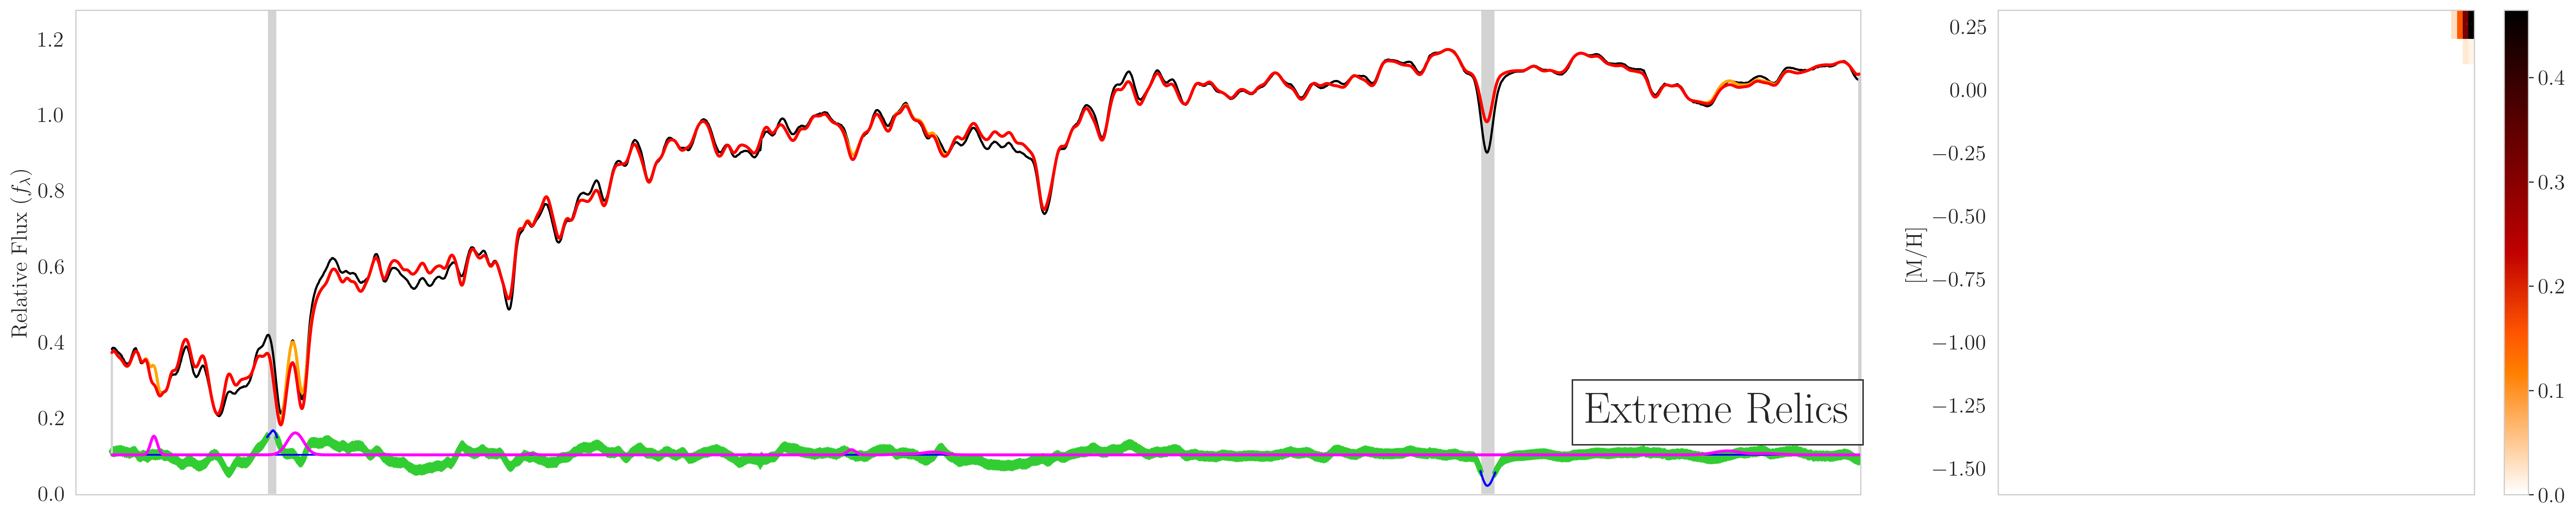

In [207]:
textstr = 'Extreme Relics'
path = '../outputs/make_plots_output/ppxf_high'+suffix+'.pdf'
type = 'high'
make_ppxf_plot(pp_high, sps1, weights_high, textstr, path,type, colour='gist_heat_r')

/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_25149/3147335916.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([f"{tick*10000:.0f}" for tick in current_ticks])


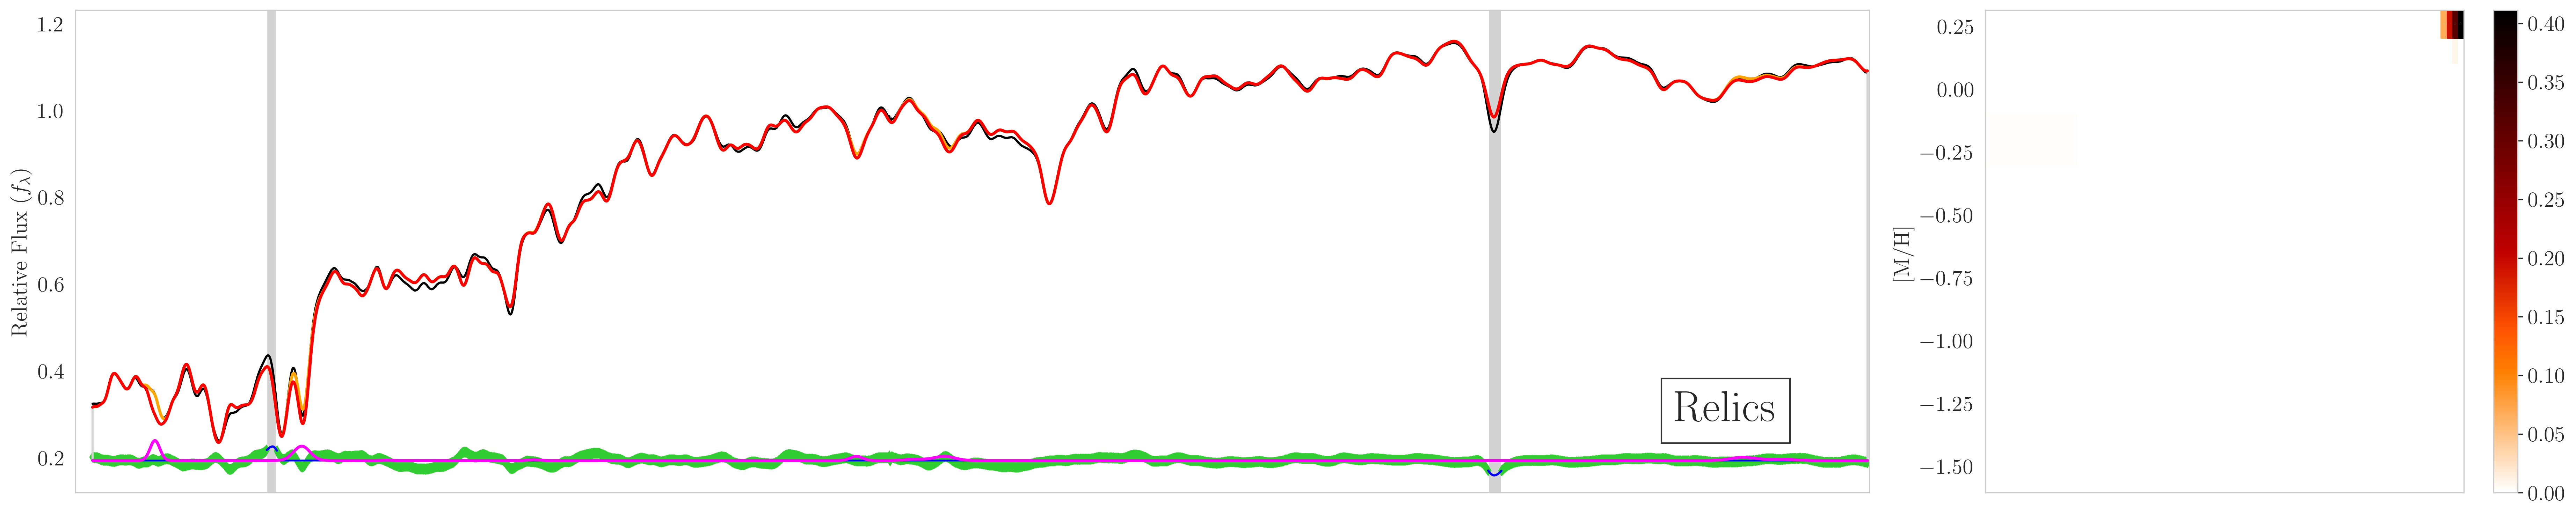

In [208]:
if len(df)==3:
    textstr = 'Relics'
    path = '../outputs/make_plots_output/ppxf_medium'+suffix+'.pdf'
    type = 'high'
    
if len(df)==2:
    textstr = 'Non-Relics'
    path = '../outputs/make_plots_output/ppxf_low'+suffix+'.pdf'
    type = 'low'
    
make_ppxf_plot(pp_med, sps2, weights_med, textstr, path,type, colour='gist_heat_r')


/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_25149/3147335916.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([f"{tick*10000:.0f}" for tick in current_ticks])


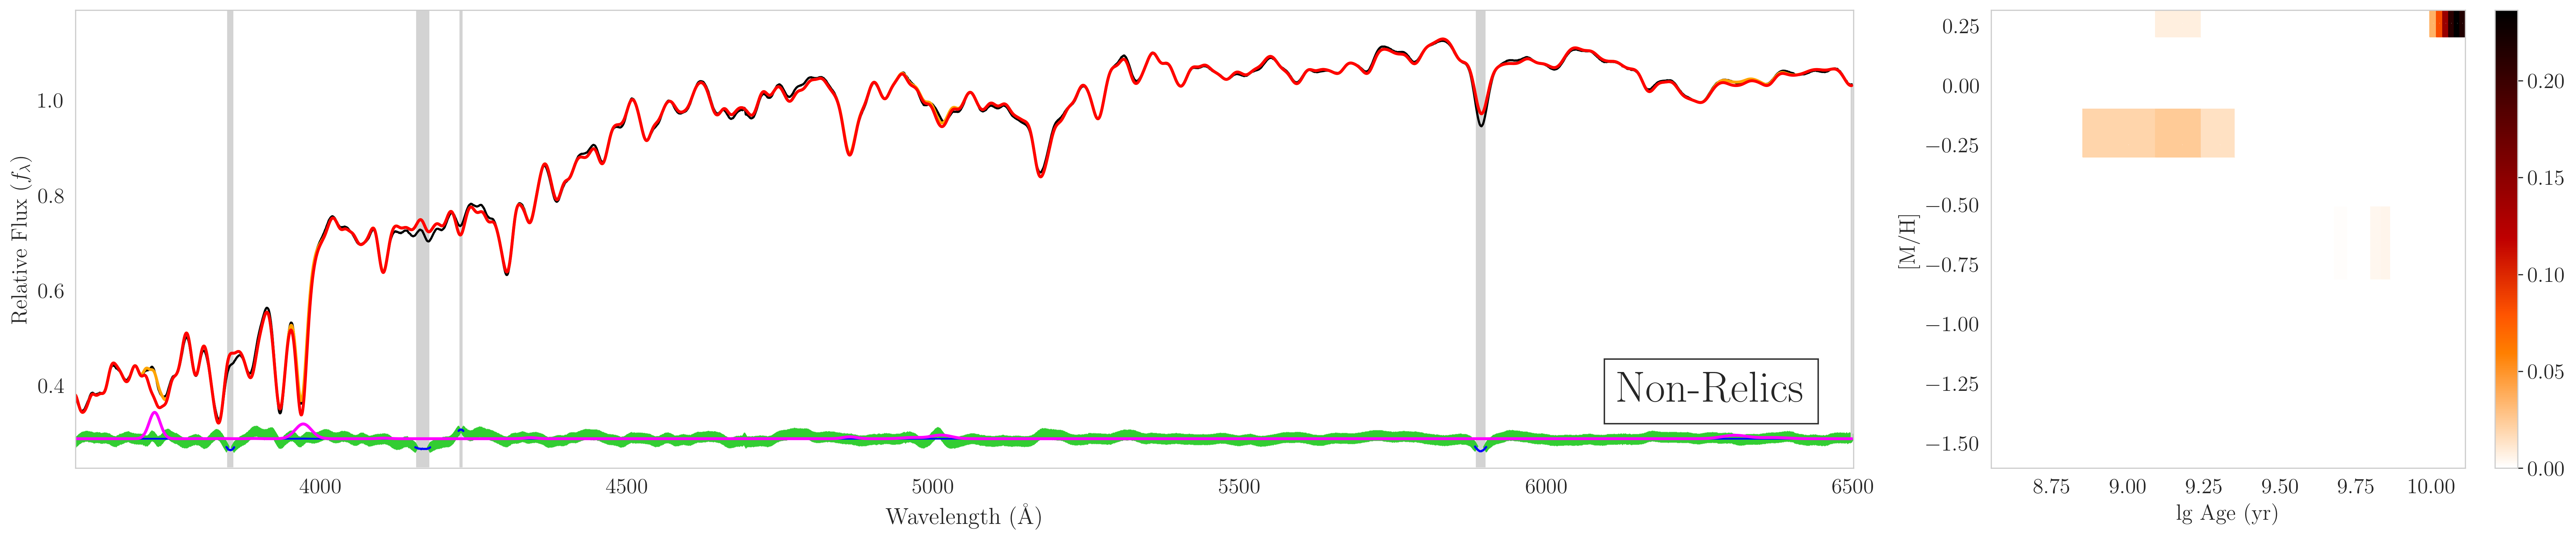

In [209]:
if len(df)==3:
    textstr = 'Non-Relics'
    path = '../outputs/make_plots_output/ppxf_low'+suffix+'.pdf'
    type = 'low'
    make_ppxf_plot(pp_low, sps, weights_low, textstr, path,type, colour = 'gist_heat_r')

## Figure 7b

Normalizing spectra at wavelength 4799.68Å
Extreme Relics flux at normalization: 0.9965
Non-Relics flux at normalization: 1.0482
Normalization factor for Non-Relics: 0.9506


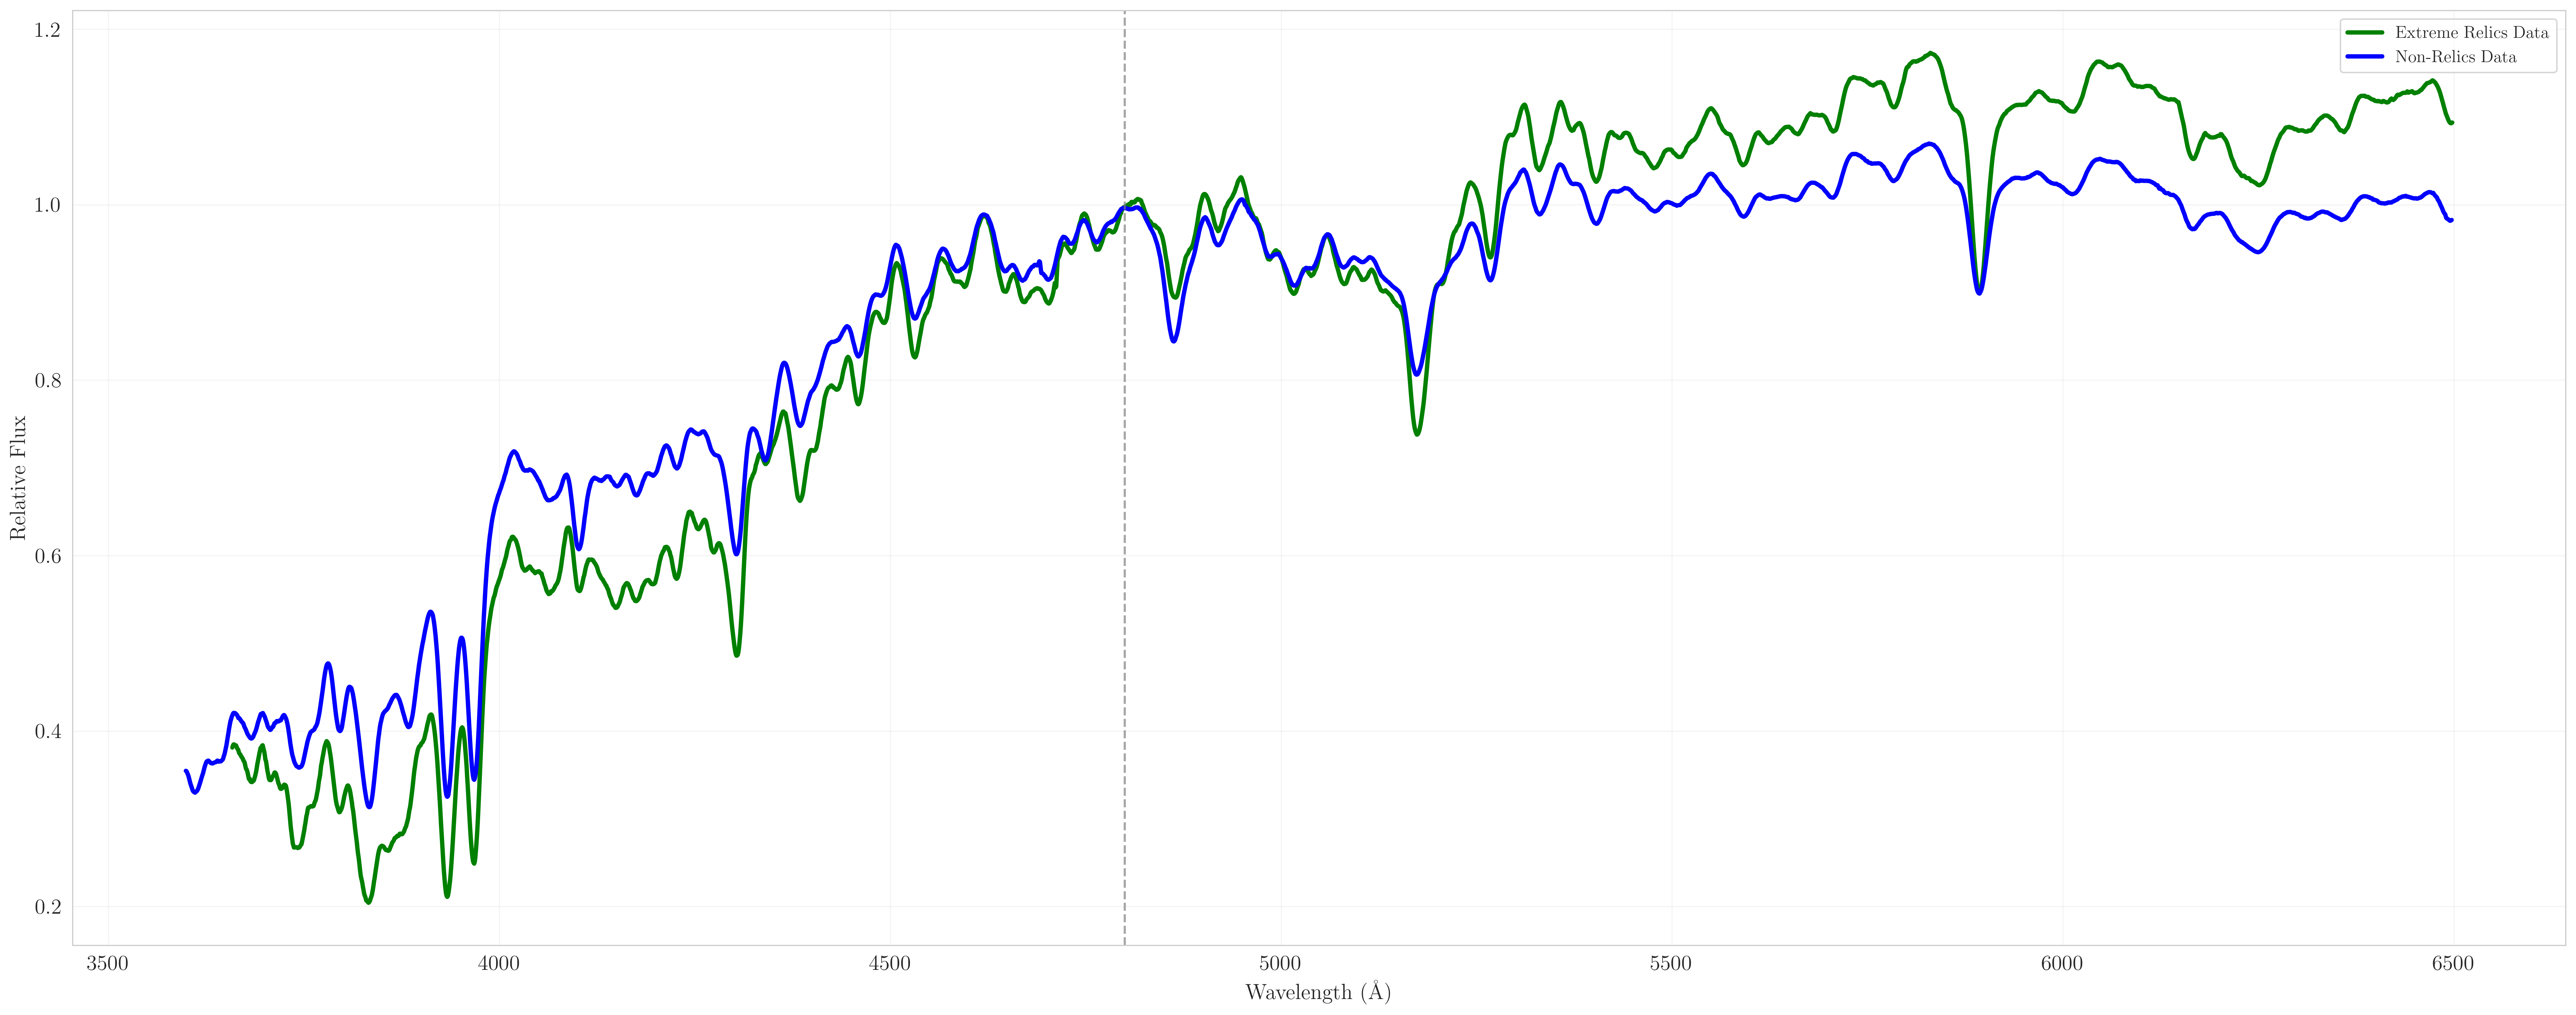

In [210]:
def make_ppxf_plots_overlaid_3(pp_high, pp_med, pp_low, high_text="Extreme Relics", med_text="Medium DoR", 
                            low_text="Non-Relics", y_offset=0.0, path='overlaid_spectra_plot'+suffix+'.pdf', 
                            normalize_at_wavelength=4800.0):
    
    fig = plt.figure(figsize=(25, 10))
    
    # First, let the Extreme Relics ppxf object plot itself (creates its own axes)
    pp_high.plot()
    
    # Get the current axes that ppxf.plot() created
    ax = plt.gca()
    
    # Get the data from all three ppxf objects
    wave_high = pp_high.lam
    galaxy_high = pp_high.galaxy
    bestfit_high = pp_high.bestfit
    
    wave_med = pp_med.lam
    galaxy_med = pp_med.galaxy
    bestfit_med = pp_med.bestfit
    
    wave_low = pp_low.lam
    galaxy_low = pp_low.galaxy
    bestfit_low = pp_low.bestfit
    
    # Normalize at the specified wavelength
    if normalize_at_wavelength is not None:
        # Find the closest index to the normalization wavelength for all three spectra
        idx_high = np.argmin(np.abs(wave_high - normalize_at_wavelength))
        idx_med = np.argmin(np.abs(wave_med - normalize_at_wavelength))
        idx_low = np.argmin(np.abs(wave_low - normalize_at_wavelength))
        
        # Get flux values at those wavelengths
        flux_high_at_norm = galaxy_high[idx_high]
        flux_med_at_norm = galaxy_med[idx_med]
        flux_low_at_norm = galaxy_low[idx_low]
        
        # Calculate normalization factors
        norm_factor_high = 1.0  # Keep Extreme Relics spectrum as reference
        norm_factor_med = flux_high_at_norm / flux_med_at_norm
        norm_factor_low = flux_high_at_norm / flux_low_at_norm
        
        # Apply normalization
        galaxy_high_norm = galaxy_high * norm_factor_high
        bestfit_high_norm = bestfit_high * norm_factor_high
        
        galaxy_med_norm = galaxy_med * norm_factor_med
        bestfit_med_norm = bestfit_med * norm_factor_med
        
        galaxy_low_norm = galaxy_low * norm_factor_low
        bestfit_low_norm = bestfit_low * norm_factor_low
        
        print(f"Normalizing spectra at wavelength {wave_high[idx_high]:.2f}Å")
        print(f"Extreme Relics flux at normalization: {flux_high_at_norm:.4f}")
        print(f"Medium DoR flux at normalization: {flux_med_at_norm:.4f}")
        print(f"Non-Relics flux at normalization: {flux_low_at_norm:.4f}")
        print(f"Normalization factor for Medium DoR: {norm_factor_med:.4f}")
        print(f"Normalization factor for Non-Relics: {norm_factor_low:.4f}")
    else:
        # If no normalization is requested, use original values
        galaxy_high_norm = galaxy_high
        bestfit_high_norm = bestfit_high
        
        galaxy_med_norm = galaxy_med
        bestfit_med_norm = bestfit_med
        
        galaxy_low_norm = galaxy_low
        bestfit_low_norm = bestfit_low
    
    # Clear the existing plot but keep the axes
    ax.clear()
    
    # Create a custom color scheme
    high_color = 'green'
    high_bestfit_color = 'red'
    
    med_color = 'orange'
    med_bestfit_color = 'magenta'
    
    low_color = 'blue'
    low_bestfit_color = 'green'
    
    # Plot Extreme Relics data and best fit
    ax.plot(wave_high, galaxy_high_norm, color=high_color, lw=3, label=f'{high_text} Data')
    # ax.plot(wave_high, bestfit_high_norm, color=high_bestfit_color, lw=2, label=f'{high_text} Best Fit')
    
    # Plot medium DoR data and best fit
    ax.plot(wave_med, galaxy_med_norm + (y_offset/2), color=med_color, lw=3, label=f'{med_text} Data')
    # ax.plot(wave_med, bestfit_med_norm + (y_offset/2), color=med_bestfit_color, lw=2, label=f'{med_text} Best Fit')
    
    # Plot Non-Relics data and best fit with the specified y-offset
    ax.plot(wave_low, galaxy_low_norm + y_offset, color=low_color, lw=3, label=f'{low_text} Data')
    # ax.plot(wave_low, bestfit_low_norm + y_offset, color=low_bestfit_color, lw=2, label=f'{low_text} Best Fit')
    
    # Add a vertical line at the normalization wavelength if specified
    if normalize_at_wavelength is not None:
        ax.axvline(x=normalize_at_wavelength, color='gray', linestyle='--', alpha=0.7)
    
    # Add a grid for reference
    ax.grid(True, alpha=0.2)
    
    # Add a legend with all three spectra
    ax.legend(loc='upper right', fontsize=12)
    
    # Add title and labels
    """title = f'Galaxy Spectra Comparison'
    if normalize_at_wavelength is not None:
        title += f' (Normalized at {normalize_at_wavelength}Å)'
    ax.set_title(title, fontsize=20)"""
    ax.set_xlabel('Wavelength (Å)', fontsize=15)
    ax.set_ylabel('Relative Flux', fontsize=15)
    
    # Final adjustments
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(path, bbox_inches='tight', dpi=300)
    
    return fig


def make_ppxf_plots_overlaid(pp_high, pp_low, high_text="Extreme Relics", low_text="Non-Relics", 
                            y_offset=0.0, path="overlaid_spectra_plot.pdf", 
                            normalize_at_wavelength=4800.0):
    
    fig = plt.figure(figsize=(25, 10))
    
    # First, let the Extreme Relics ppxf object plot itself (creates its own axes)
    pp_high.plot()
    
    # Get the current axes that ppxf.plot() created
    ax = plt.gca()
    
    # Get the data from both ppxf objects
    wave_high = pp_high.lam
    galaxy_high = pp_high.galaxy
    bestfit_high = pp_high.bestfit
    
    wave_low = pp_low.lam
    galaxy_low = pp_low.galaxy
    bestfit_low = pp_low.bestfit
    
    # Normalize at the specified wavelength
    if normalize_at_wavelength is not None:
        # Find the closest index to the normalization wavelength for both spectra
        idx_high = np.argmin(np.abs(wave_high - normalize_at_wavelength))
        idx_low = np.argmin(np.abs(wave_low - normalize_at_wavelength))
        
        # Get flux values at those wavelengths
        flux_high_at_norm = galaxy_high[idx_high]
        flux_low_at_norm = galaxy_low[idx_low]
        
        # Calculate normalization factors
        norm_factor_high = 1.0  # Keep Extreme Relics spectrum as reference
        norm_factor_low = flux_high_at_norm / flux_low_at_norm
        
        # Apply normalization
        galaxy_high_norm = galaxy_high * norm_factor_high
        bestfit_high_norm = bestfit_high * norm_factor_high
        galaxy_low_norm = galaxy_low * norm_factor_low
        bestfit_low_norm = bestfit_low * norm_factor_low
        
        print(f"Normalizing spectra at wavelength {wave_high[idx_high]:.2f}Å")
        print(f"Extreme Relics flux at normalization: {flux_high_at_norm:.4f}")
        print(f"Non-Relics flux at normalization: {flux_low_at_norm:.4f}")
        print(f"Normalization factor for Non-Relics: {norm_factor_low:.4f}")
    else:
        # If no normalization is requested, use original values
        galaxy_high_norm = galaxy_high
        bestfit_high_norm = bestfit_high
        galaxy_low_norm = galaxy_low
        bestfit_low_norm = bestfit_low
    
    # Clear the existing plot but keep the axes
    ax.clear()
    
    # Create a custom color scheme
    high_color = 'green'
    high_bestfit_color = 'red'
    
    low_color = 'blue'
    low_bestfit_color = 'green'
    
    # Plot Extreme Relics data and best fit
    ax.plot(wave_high, galaxy_high_norm, color=high_color, lw=3, label=f'{high_text} Data')
    # ax.plot(wave_high, bestfit_high_norm, color=high_bestfit_color, lw=2, label=f'{high_text} Best Fit')
    
    # Plot Non-Relics data and best fit with the specified y-offset
    ax.plot(wave_low, galaxy_low_norm + y_offset, color=low_color, lw=3, label=f'{low_text} Data')
    # ax.plot(wave_low, bestfit_low_norm + y_offset, color=low_bestfit_color, lw=2, label=f'{low_text} Best Fit')
    
    # Add a vertical line at the normalization wavelength if specified
    if normalize_at_wavelength is not None:
        ax.axvline(x=normalize_at_wavelength, color='gray', linestyle='--', alpha=0.7)
    
    # Add a grid for reference
    ax.grid(True, alpha=0.2)
    
    # Add a legend with both spectra
    ax.legend(loc='upper right', fontsize=12)
    
    # Add title and labels
    """title = f'Galaxy Spectra Comparison'
    if normalize_at_wavelength is not None:
        title += f' (Normalized at {normalize_at_wavelength}Å)'
    ax.set_title(title, fontsize=20)"""
    ax.set_xlabel('Wavelength (Å)', fontsize=15)
    ax.set_ylabel('Relative Flux', fontsize=15)
    
    # Final adjustments
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(path, bbox_inches='tight', dpi=300)
    
    return fig

if len(df)==2:
    make_ppxf_plots_overlaid(pp_high, pp_med,high_text="Extreme Relics", low_text="Non-Relics",y_offset=0.0,
                             path='../outputs/make_plots_output/coplotted_spectra'+suffix+'.pdf',normalize_at_wavelength=4800)
else:
    make_ppxf_plots_overlaid(pp_high, pp_low,high_text="Extreme Relics", low_text="Non-Relics",y_offset=0.0,
                             path='../outputs/make_plots_output/coplotted_spectra'+suffix+'.pdf',normalize_at_wavelength=4800)
    # make_ppxf_plots_overlaid_3(pp_high, pp_med, pp_low,high_text="Extreme Relics", med_text="Medium DoR",low_text="Non-Relics",y_offset=0.0,
                                # path="../outputs/make_plots_output/coplotted_spectra.pdf",normalize_at_wavelength=4800)

## Figure 8

In [211]:
"""fig, axs = plt.subplots(1, 2, figsize=(15, 7))
props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='black')

# Create a smaller dataframe with just the two galaxies you want to plot
# Example: choose galaxies 0 and 2 from your stacked regression set

if len(df)==3:
    galaxy_ids = [0,2]
else:
    galaxy_ids = [0,1]
    
df_subset = pd.DataFrame({
    "filename": [f"data/stacked_fits/stacked_REGRESSION_{id}.fits" for id in galaxy_ids]
})

for idx, (index, row) in enumerate(df_subset.iterrows()):
    # Get the file ID
    galaxy_id = galaxy_ids[idx]
    
    # Set up your file paths as in your original code
    fitsfile1 = f'../outputs/ppxf_fits/stacked_REGRESSION_{galaxy_id}_ppxfout_UNR.fits'
    fitsfile2 = f'../outputs/ppxf_fits/stacked_REGRESSION_{galaxy_id}_ppxfout_REGUL.fits'
    
    # Process the files exactly as in your original code
    name1, z1, agesplot1, weiplot1, univ_age1 = read_fits_summary(fitsfile1)
    name2, z2, agesplot2, weiplot2, univ_age2 = read_fits_summary(fitsfile2)

    masses = [weiplot1, weiplot2]
    mean_masses = np.mean(masses, axis=0)
    std_masses = np.std(masses, axis=0)

    # Plot using the appropriate subplot (index 0 or 1)
    ax = axs[idx]
    
    # The rest is the same as your original code, but using ax instead of axs[index%3,index//3]
    ax.set_xlim(0, 13.5)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('Time since BB (Gyr)', fontsize=15)
    ax.set_ylabel(r'Cumulative mass \%', fontsize=15)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', direction='in', labelsize=15)
    
    ax.axhline(0.75, color='gray', alpha=0.2)
    ax.text(12, 0.76, r'75\%', style='italic', color='gray', fontsize=10)
    ax.axhline(0.95, color='gray', alpha=0.2)
    ax.text(12, 0.96, r'95\%', style='italic', color='gray', fontsize=10)
    ax.axvline(3.0, color='gray', alpha=0.2, linestyle='-.', linewidth=2.0)
    # ax.axvline(univ_age1, color='gray', linestyle='-.', linewidth=2.0)

    # Add custom labels for Extreme Relics and Non-Relics
    label = "Extreme Relics" if idx == 0 else "Non-Relics"
    ax.text(0.8, 0.1, label, transform=ax.transAxes, fontsize=15,
            verticalalignment='top', bbox=props, ha='center')
    
    ax.plot(agesplot1, mean_masses, color='black', linewidth=3.0)
    ax.fill_between(agesplot1, mean_masses-std_masses, mean_masses+std_masses, color='black', alpha=0.1)
    
    #ax.text(univ_age1-0.1, 0.1, 'today', color='gray', style='italic', rotation=90, horizontalalignment='right', fontsize=10)
    ax.text(2.9, 0.0, r'z$\sim$2', style='italic', color='gray', rotation=90, 
            horizontalalignment='right', fontsize=10)
    ax.set_xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0])
    ax.set_yticklabels([f"{tick*100:.0f}" for tick in ax.get_yticks()])

plt.tight_layout()
plt.savefig('../outputs/make_plots_output/mass_formation'+suffix+'.pdf', bbox_inches='tight', dpi=300)
plt.show()"""

print("Skip")

Skip


## Figure 10

In [212]:
"""df_e2 = pd.read_csv('../outputs/stacked_catalogues/CATALOGUE_REGRESSION.csv')
df_e1 = pd.read_csv('../data/ppxf_stel_pop_dor_final.csv')
# Identify the essential columns needed for the plots

# Calculate t_ass_err using numpy's nanstd function directly
t_ass_values = np.nanstd([
    (0.7 + (df_e2['univ_age'] - df_e2['time_100'])) / df_e2['univ_age'],
    (0.7 + (df_e2['univ_age'] - df_e2['time_100_reg'])) / df_e2['univ_age'],
    (0.7 + (df_e2['univ_age'] - df_e2['time_100_unr'])) / df_e2['univ_age'],
    (0.7 + (df_e2['univ_age'] - df_e2['time_100_plus'])) / df_e2['univ_age'],
    (0.7 + (df_e2['univ_age'] - df_e2['time_100_min'])) / df_e2['univ_age']
], axis=0)

df_e2['t_ass_err'] = t_ass_values

'''df_for_std = pd.DataFrame()
# Calculate the standard metric for each estimate of time_100
df_for_std['reg'] = (0.7 + (df_e2['univ_age'] - df_e2['time_100_reg'])) / df_e2['univ_age']
df_for_std['unreg'] = (0.7 + (df_e2['univ_age'] - df_e2['time_100_unr'])) / df_e2['univ_age']
df_for_std['plus'] = (0.7 + (df_e2['univ_age'] - df_e2['time_100_plus'])) / df_e2['univ_age']
df_for_std['minus'] = (0.7 + (df_e2['univ_age'] - df_e2['time_100_min'])) / df_e2['univ_age']
# Calculate the standard deviation along rows, ignoring NaNs
df_e2['t_ass_err'] = df_for_std.std(axis=1, skipna=True)'''

essential_cols = [
    'dor', 
    'mass_frac', 'mass_frac_reg', 'mass_frac_unr', 'mass_frac_plus', 'mass_frac_min',
    'time_75', 'time_75_reg', 'time_75_unr', 'time_75_plus', 'time_75_min',
    'univ_age', 'time_100', 't_ass_err'
]

# Filter each dataframe to only include these columns (if they exist)
df_e2_cols = [col for col in essential_cols if col in df_e2.columns]
df_e1_cols = [col for col in essential_cols if col in df_e1.columns]

# Create shortened dataframes
df_e2_short = df_e2[df_e2_cols].copy()
df_e1_short = df_e1[df_e1_cols].copy()

# Add a source column to track the origin
df_e2_short['source'] = 'E-INSPIRE II'
df_e1_short['source'] = 'E-INSPIRE I'

# Combine the dataframes
combined_df = pd.concat([df_e2_short, df_e1_short], ignore_index=True)

df = combined_df"""

print("Skip")

Skip


In [213]:
"""# fig, axs = plt.subplots(3, 1, sharex=True, figsize=(5, 12))
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
# fig.subplots_adjust(hspace=0.01)

# Create a mask for E-INSPIRE II and E-INSPIRE I data points
mask_einspire_ii = df['source'] == 'E-INSPIRE II'
mask_einspire_i = df['source'] == 'E-INSPIRE I'

# First subplot - mass fraction
axs[0].axvline(0.3, color='0.6', linestyle='-.', linewidth=1, zorder=0)
axs[0].axvline(0.6, color='0.6', linestyle='-.', linewidth=1, zorder=0)
axs[0].set_ylim(top=1.05, bottom=-0.3)

# Calculate errors
err_mass_frac = np.nanstd([df['mass_frac_reg'].values, df['mass_frac_unr'].values, df['mass_frac_plus'], df['mass_frac_min']], axis=0)

# Plot E-INSPIRE II (in red)
axs[0].errorbar(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'mass_frac'], 
                yerr=err_mass_frac[mask_einspire_ii], fmt='none', c='r', zorder=1, 
                capsize=2, elinewidth=1, capthick=1)
axs[0].scatter(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'mass_frac'], 
               s=25, c='red', marker='o', linewidths=0.5, label='E-INSPIRE II', zorder=10)

# Plot E-INSPIRE I (in black)
axs[0].errorbar(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'mass_frac'], 
                yerr=err_mass_frac[mask_einspire_i], fmt='none', c='grey', zorder=1, 
                capsize=1.5, elinewidth=0.3, capthick=0.3)
axs[0].scatter(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'mass_frac'], 
               s=5, c='grey', label='E-INSPIRE I')

axs[0].set_xlabel('DoR')
axs[0].set_ylabel(r'$f_{M^{\star}_{t\mathrm{BB}=3}}$')
axs[0].minorticks_on()
axs[0].tick_params(axis='both',which='major',direction='inout')
axs[0].tick_params(axis='both',which='minor',direction='in')

# Second subplot - time_75
axs[1].axvline(0.3, color='0.6', linestyle='-.', linewidth=1, zorder=0)
axs[1].axvline(0.6, color='0.6', linestyle='-.', linewidth=1, zorder=0)
axs[1].set_ylim(top=15.5, bottom=0)

# Calculate errors
err_time_75 = np.nanstd([df['time_75_reg'].values, df['time_75_unr'].values, df['time_75_plus'], df['time_75_min']], axis=0)

# Plot E-INSPIRE II (in red)
axs[1].errorbar(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'time_75'], 
                yerr=err_time_75[mask_einspire_ii], fmt='none', c='r', zorder=1, 
                capsize=2, elinewidth=1, capthick=1)
axs[1].scatter(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'time_75'], 
               s=25, c='red', marker='o', linewidths=0.5, zorder=10)

# Plot E-INSPIRE I (in black)
axs[1].errorbar(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'time_75'], 
                yerr=err_time_75[mask_einspire_i], fmt='none', c='grey', zorder=1, 
                capsize=1.5, elinewidth=0.3, capthick=0.3)
axs[1].scatter(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'time_75'], 
               s=5, c='grey')

axs[1].set_xlabel('DoR')
axs[1].set_ylabel(r't$_{75}$ [Gyr]')
axs[1].minorticks_on()
axs[1].tick_params(axis='both',which='major',direction='inout')
axs[1].tick_params(axis='both',which='minor',direction='in')

# Third subplot - universe age calculation
axs[2].axvline(0.3, color='0.6', linestyle='-.', linewidth=1, zorder=0)
axs[2].axvline(0.6, color='0.6', linestyle='-.', linewidth=1, zorder=0)

# Calculate the ratio values
ratio_values = (np.array(df['univ_age'])-np.array(df['time_100']))/np.array(df['univ_age'])
#ratio_values = np.array(df['time_100'])

# Plot E-INSPIRE II (in red)
axs[2].errorbar(df.loc[mask_einspire_ii, 'dor'], ratio_values[mask_einspire_ii], 
                fmt='none', yerr=df.loc[mask_einspire_ii, 't_ass_err'], c='r', zorder=1, 
                capsize=2, elinewidth=1, capthick=1)
axs[2].scatter(df.loc[mask_einspire_ii, 'dor'], ratio_values[mask_einspire_ii], 
               s=25, c='red', marker='o', linewidths=0.5, zorder=10)

# Plot E-INSPIRE I (in black)
axs[2].errorbar(df.loc[mask_einspire_i, 'dor'], ratio_values[mask_einspire_i], 
                fmt='none', yerr=df.loc[mask_einspire_i, 't_ass_err'], c='grey', zorder=1, 
                capsize=1.5, elinewidth=0.3, capthick=0.3)
axs[2].scatter(df.loc[mask_einspire_i, 'dor'], ratio_values[mask_einspire_i], 
               s=5, c='grey')

axs[2].set_xlabel('DoR')
axs[2].set_xticks([0, 0.2, 0.4, 0.6, 0.8])
axs[2].set_ylabel(r'$(t_{\mathrm{Uni}} - t_{\mathrm{fin}})/t_{\mathrm{Uni}}$')
axs[2].minorticks_on()
axs[2].tick_params(axis='both',which='major',direction='inout')
axs[2].tick_params(axis='both',which='minor',direction='in')

# Add legend at the top of the figure
plt.figlegend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=12, fancybox=False, edgecolor='black')

# Optional: Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../outputs/make_plots_output/DoR_params'+suffix+'.pdf', bbox_inches='tight', dpi=300)"""
print("Skip")

Skip


## Figure 11


In [214]:
df_e2 = pd.read_csv('../outputs/stacked_catalogues/CATALOGUE_REGRESSION.csv')
df_e1 = pd.read_csv('../data/ppxf_stel_pop_dor_final.csv')  # Assuming this is your second dataframe

In [215]:
"""# Version with only top row
df_e2 = pd.read_csv('../outputs/stacked_catalogues/CATALOGUE_REGRESSION.csv')
df_e1 = pd.read_csv('../data/ppxf_stel_pop_dor_final.csv')  # Assuming this is your second dataframe

column_mapping = {
    # df_e1 column name: df_e2 column name
    'velDisp_ppxf': 'vel_disp_avg',
    'velDisp_ppxf_err': 'vel_disp_err',   
}

# Rename columns in df_e1
df_e1 = df_e1.rename(columns=column_mapping)
df_e1['age_mean'] = 10**df_e1['logAge_mean']

# Process df_e2
df_e2['age_mean'] = 10**df_e2['logAge']
df_e2['age_min'] = 10**df_e2['logAge_minus']
df_e2['age_plus'] = 10**df_e2['logAge_plus']

df_e2['age_err_lower'] = abs(df_e2['age_mean'] - df_e2['age_min'])
df_e2['age_err_upper'] = abs(df_e2['age_plus'] - df_e2['age_mean'])
df_e2['age_err'] = (df_e2['age_err_lower'] + df_e2['age_err_upper']) / 2

df_e2['[M/H]_mean'] = df_e2['[M/H]']
df_e2['[M/H]_err_lower'] = abs(df_e2['[M/H]_mean'] - df_e2['[M/H]_minus'])
df_e2['[M/H]_err_upper'] = abs(df_e2['[M/H]_plus'] - df_e2['[M/H]_mean'])
df_e2['[M/H]_err'] = (df_e2['[M/H]_err_lower'] + df_e2['[M/H]_err_upper']) / 2


df_e2['source'] = 'E-INSPIRE II'
df_e1['source'] = 'E-INSPIRE I'

# Combine the dataframes
# Use only columns that exist in both dataframes
common_columns = list(set(df_e2.columns).intersection(set(df_e1.columns)))
df_e2_subset = df_e2[common_columns]
df_e1_subset = df_e1[common_columns]
df = pd.concat([df_e2_subset, df_e1_subset], ignore_index=True)

# Create masks for plotting
mask_einspire_ii = df['source'] == 'E-INSPIRE II'
mask_einspire_i = df['source'] == 'E-INSPIRE I'

# Create the figure and subplots - modified to only have 1 row with 3 columns
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# First subplot: Velocity dispersion
# Plot E-INSPIRE I (grey) points first
axs[0].errorbar(df.loc[mask_einspire_i, 'dor'], np.log10(df.loc[mask_einspire_i, 'vel_disp_avg']), 
                yerr=(df.loc[mask_einspire_i, 'vel_disp_err']/df.loc[mask_einspire_i, 'vel_disp_avg'])/np.log(10), 
                fmt='none', c='grey', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9, alpha=0.7)
axs[0].scatter(df.loc[mask_einspire_i, 'dor'], np.log10(df.loc[mask_einspire_i, 'vel_disp_avg']), 
              s=5, c='grey', alpha=0.7)

# Plot E-INSPIRE II (red) points on top
axs[0].errorbar(df.loc[mask_einspire_ii, 'dor'], np.log10(df.loc[mask_einspire_ii, 'vel_disp_avg']), 
                yerr=(df.loc[mask_einspire_ii, 'vel_disp_err']/df.loc[mask_einspire_ii, 'vel_disp_avg'])/np.log(10), 
                fmt='none', c='r', zorder=9, capsize=3, elinewidth=1.5, capthick=1.5)
axs[0].scatter(df.loc[mask_einspire_ii, 'dor'], np.log10(df.loc[mask_einspire_ii, 'vel_disp_avg']), 
              s=30, c='red', marker='o', linewidths=0.7, zorder=10)

axs[0].set_xlabel('DoR')
axs[0].set_ylabel(r'$\log(\sigma_{\star}$ [km/s])')
axs[0].minorticks_on()
axs[0].set_xticks([0., 0.2, 0.4, 0.6, 0.8])

# Second subplot: Stellar age
# Plot E-INSPIRE I (grey) points first
axs[1].errorbar(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'age_mean'], 
                yerr=df.loc[mask_einspire_i, 'age_err'], 
                fmt='none', c='grey', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9, alpha=0.7)
axs[1].scatter(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'age_mean'], 
              s=5, c='grey', alpha=0.7)

# Plot E-INSPIRE II (red) points on top
axs[1].errorbar(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'age_mean'], 
                yerr=df.loc[mask_einspire_ii, 'age_err'], 
                fmt='none', c='r', zorder=9, capsize=3, elinewidth=1.5, capthick=1.5)
axs[1].scatter(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'age_mean'], 
              s=30, c='red', marker='o', linewidths=0.7, zorder=10)

axs[1].set_xlabel('DoR')
axs[1].set_ylabel('Stellar age [Gyr]')
axs[1].minorticks_on()
axs[1].set_xticks([0., 0.2, 0.4, 0.6, 0.8])

# Third subplot: Metallicity
# Plot E-INSPIRE I (grey) points first
axs[2].errorbar(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, '[M/H]_mean'], 
                yerr=df.loc[mask_einspire_i, '[M/H]_err'], 
                fmt='none', c='grey', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9, alpha=0.7)
axs[2].scatter(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, '[M/H]_mean'], 
              s=5, c='grey', alpha=0.7)

# Plot E-INSPIRE II (red) points on top
axs[2].errorbar(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, '[M/H]_mean'], 
                yerr=df.loc[mask_einspire_ii, '[M/H]_err'], 
                fmt='none', c='r', zorder=9, capsize=3, elinewidth=1.5, capthick=1.5)
axs[2].scatter(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, '[M/H]_mean'], 
              s=30, c='red', marker='o',linewidths=0.7, zorder=10)

axs[2].set_xlabel('DoR')
axs[2].set_ylabel('[M/H]')
axs[2].minorticks_on()
axs[2].set_xticks([0., 0.2, 0.4, 0.6, 0.8])

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
             markersize=10, label='E-INSPIRE II'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', 
           markersize=5, label='E-INSPIRE I')
]
fig.legend(handles=legend_elements, loc='upper center', 
           bbox_to_anchor=(0.5, 1.01), ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('../outputs/make_plots_output/physical_params'+suffix+'.pdf', bbox_inches='tight', dpi=300)

"""

print("Skip")

Skip


## Figue 11 and 10 combined

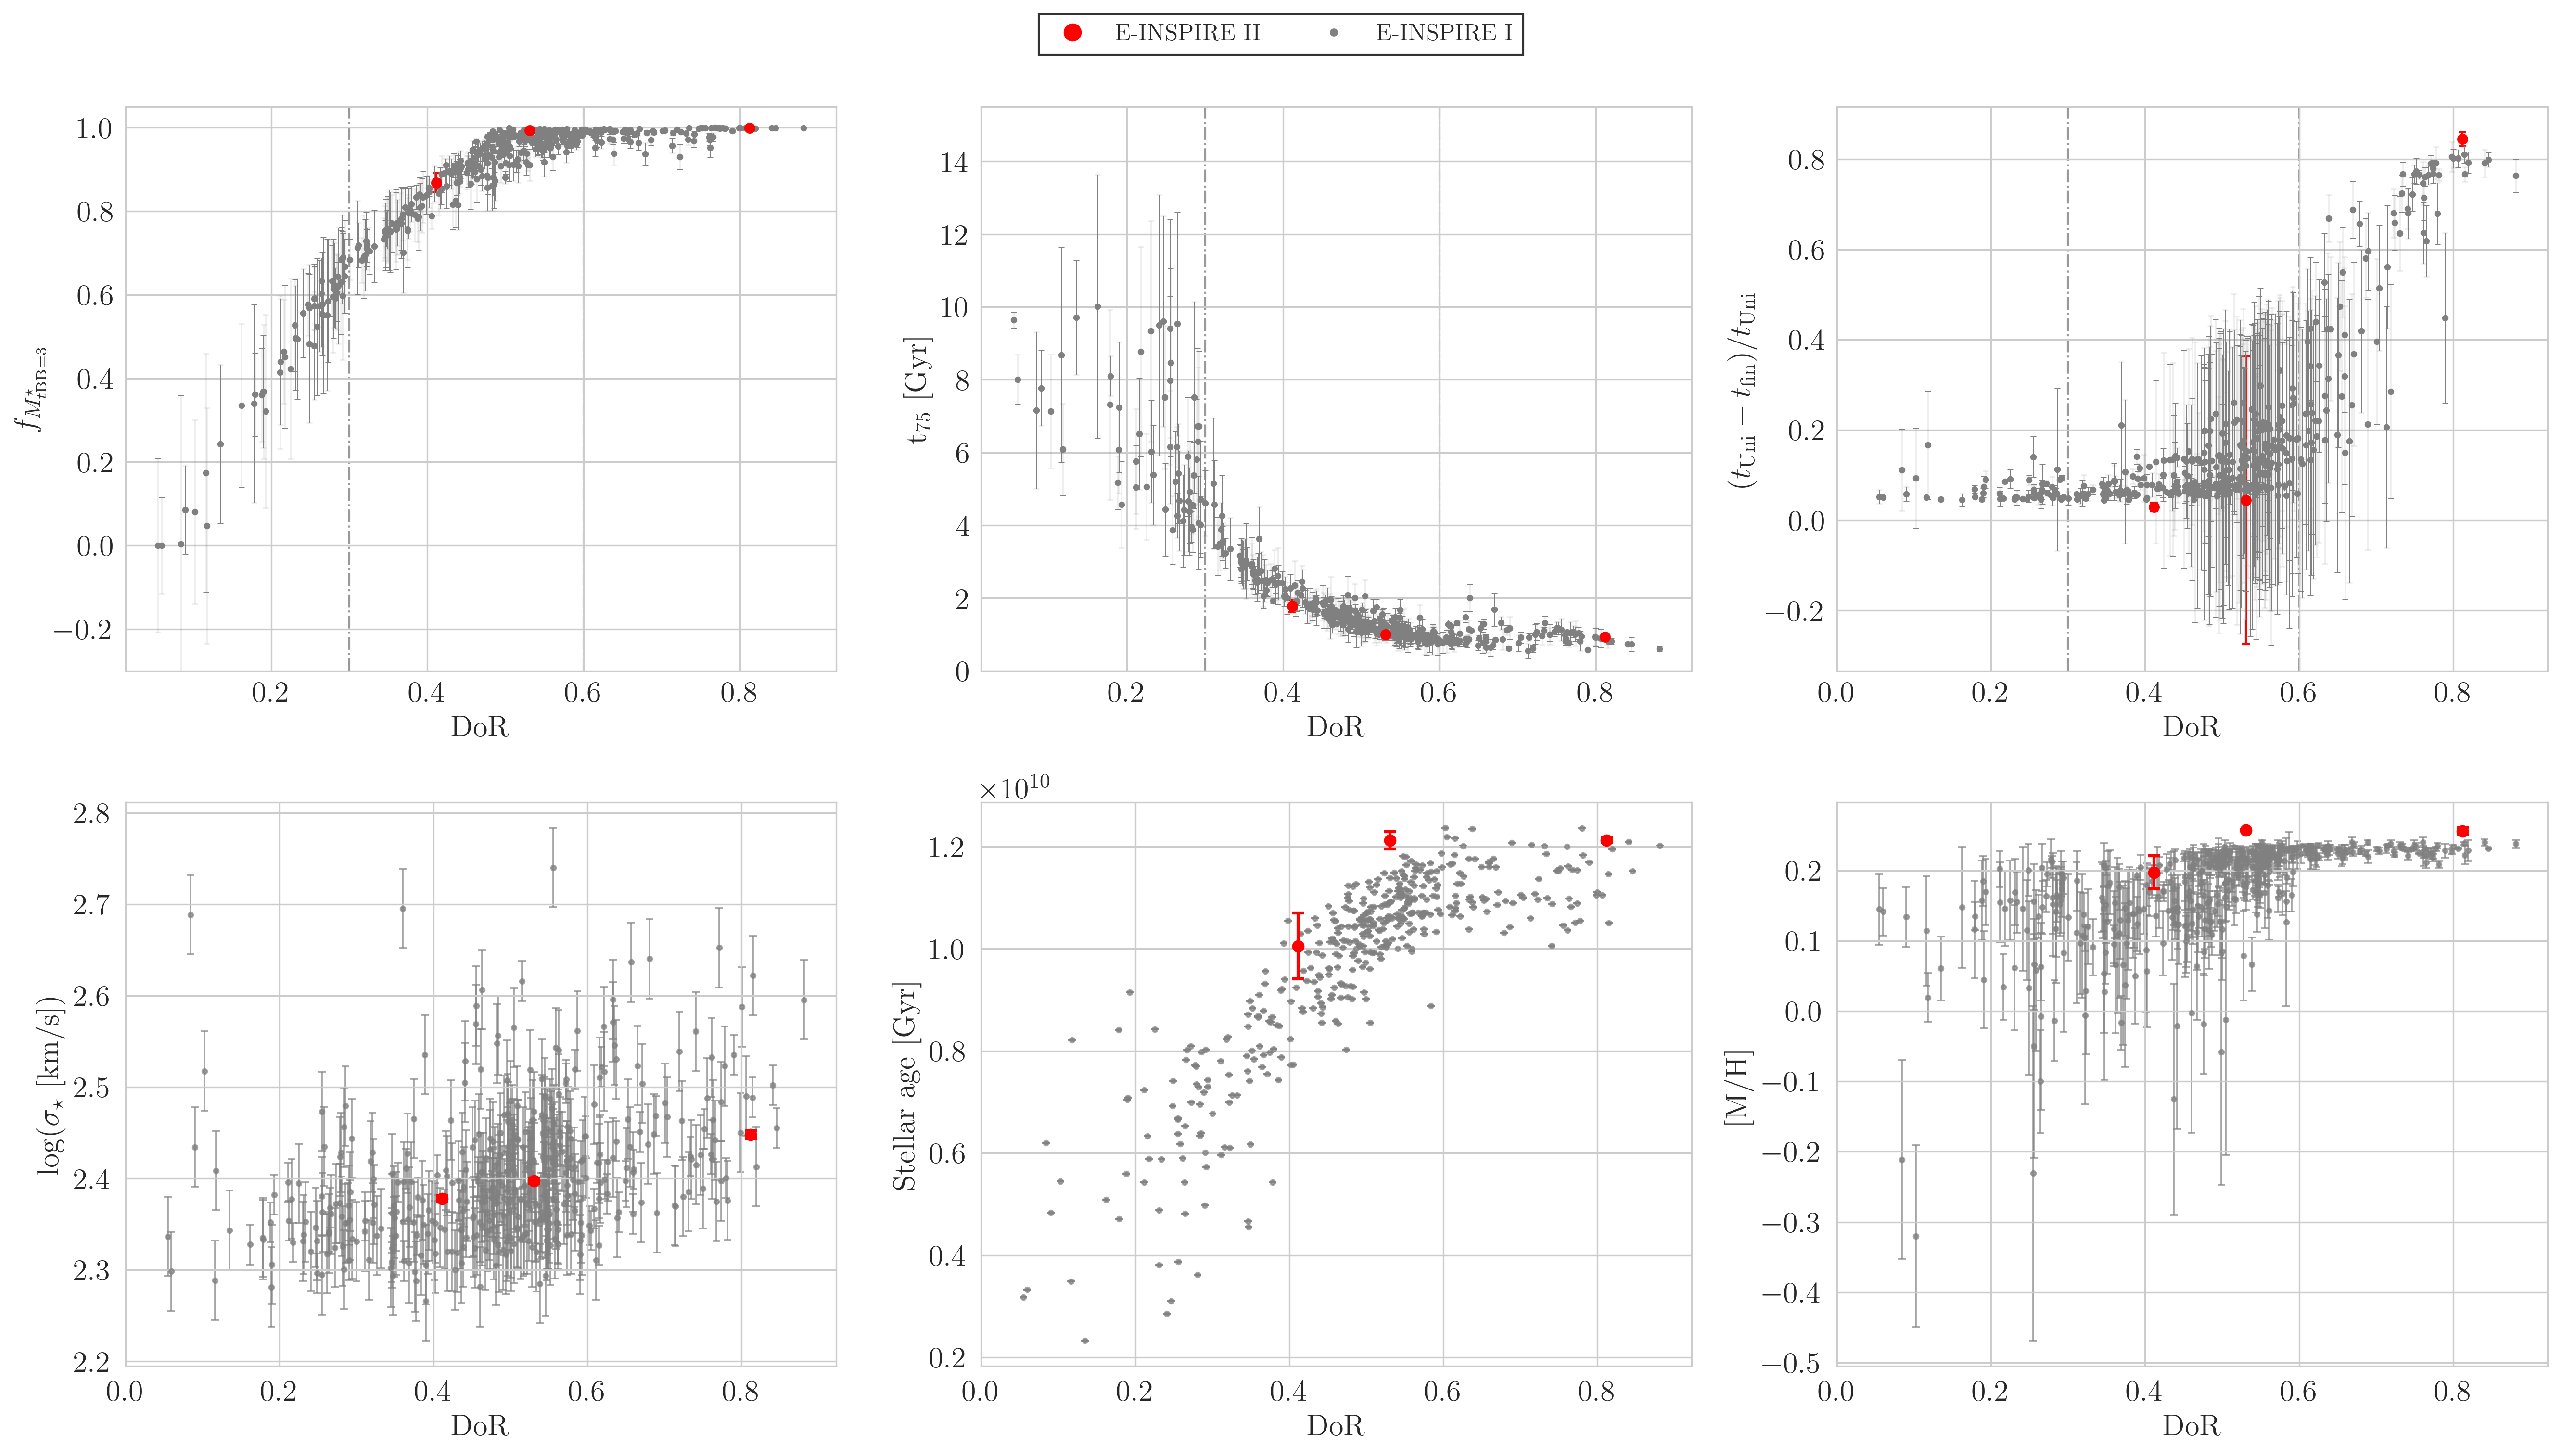

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load data for both sets of plots
df_e2 = pd.read_csv('../outputs/stacked_catalogues/CATALOGUE_REGRESSION.csv')
df_e1 = pd.read_csv('../data/ppxf_stel_pop_dor_final.csv')

# Calculate t_ass_err using numpy's nanstd function directly
t_ass_values = np.nanstd([
    (0.7 + (df_e2['univ_age'] - df_e2['time_100'])) / df_e2['univ_age'],
    (0.7 + (df_e2['univ_age'] - df_e2['time_100_reg'])) / df_e2['univ_age'],
    (0.7 + (df_e2['univ_age'] - df_e2['time_100_unr'])) / df_e2['univ_age'],
    (0.7 + (df_e2['univ_age'] - df_e2['time_100_plus'])) / df_e2['univ_age'],
    (0.7 + (df_e2['univ_age'] - df_e2['time_100_min'])) / df_e2['univ_age']
], axis=0)

df_e2['t_ass_err'] = t_ass_values

# Essential columns for first plot
essential_cols = [
    'dor', 
    'mass_frac', 'mass_frac_reg', 'mass_frac_unr', 'mass_frac_plus', 'mass_frac_min',
    'time_75', 'time_75_reg', 'time_75_unr', 'time_75_plus', 'time_75_min',
    'univ_age', 'time_100', 't_ass_err'
]

# Filter each dataframe to only include these columns (if they exist)
df_e2_cols = [col for col in essential_cols if col in df_e2.columns]
df_e1_cols = [col for col in essential_cols if col in df_e1.columns]

# Create shortened dataframes
df_e2_short = df_e2[df_e2_cols].copy()
df_e1_short = df_e1[df_e1_cols].copy()

# Add a source column to track the origin
df_e2_short['source'] = 'E-INSPIRE II'
df_e1_short['source'] = 'E-INSPIRE I'

# Combine the dataframes for first set of plots
df = pd.concat([df_e2_short, df_e1_short], ignore_index=True)

# Process data for the second set of plots
column_mapping = {
    # df_e1 column name: df_e2 column name
    'velDisp_ppxf': 'vel_disp_avg',
    'velDisp_ppxf_err': 'vel_disp_err',   
}

# Rename columns in df_e1
df_e1 = df_e1.rename(columns=column_mapping)
df_e1['age_mean'] = 10**df_e1['logAge_mean']

# Process df_e2
df_e2['age_mean'] = 10**df_e2['logAge']
df_e2['age_min'] = 10**df_e2['logAge_minus']
df_e2['age_plus'] = 10**df_e2['logAge_plus']

df_e2['age_err_lower'] = abs(df_e2['age_mean'] - df_e2['age_min'])
df_e2['age_err_upper'] = abs(df_e2['age_plus'] - df_e2['age_mean'])
df_e2['age_err'] = (df_e2['age_err_lower'] + df_e2['age_err_upper']) / 2

df_e2['[M/H]_mean'] = df_e2['[M/H]']
df_e2['[M/H]_err_lower'] = abs(df_e2['[M/H]_mean'] - df_e2['[M/H]_minus'])
df_e2['[M/H]_err_upper'] = abs(df_e2['[M/H]_plus'] - df_e2['[M/H]_mean'])
df_e2['[M/H]_err'] = (df_e2['[M/H]_err_lower'] + df_e2['[M/H]_err_upper']) / 2

# Set source for second set of plots
df_e2['source'] = 'E-INSPIRE II'
df_e1['source'] = 'E-INSPIRE I'

# Combine the dataframes for physical params (second set of plots)
common_columns = list(set(df_e2.columns).intersection(set(df_e1.columns)))
df_e2_subset = df_e2[common_columns]
df_e1_subset = df_e1[common_columns]
df_physical = pd.concat([df_e2_subset, df_e1_subset], ignore_index=True)

# Create masks for plotting
mask_einspire_ii = df['source'] == 'E-INSPIRE II'
mask_einspire_i = df['source'] == 'E-INSPIRE I'

mask_physical_ii = df_physical['source'] == 'E-INSPIRE II'
mask_physical_i = df_physical['source'] == 'E-INSPIRE I'

# Create the 2x3 panel figure
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# First row, first subplot - mass fraction
axs[0, 0].axvline(0.3, color='0.6', linestyle='-.', linewidth=1, zorder=0)
axs[0, 0].axvline(0.6, color='0.6', linestyle='-.', linewidth=1, zorder=0)
axs[0, 0].set_ylim(top=1.05, bottom=-0.3)

# Calculate errors
err_mass_frac = np.nanstd([df['mass_frac_reg'].values, df['mass_frac_unr'].values, df['mass_frac_plus'], df['mass_frac_min']], axis=0)

# Plot E-INSPIRE II (in red)
axs[0, 0].errorbar(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'mass_frac'], 
                yerr=err_mass_frac[mask_einspire_ii], fmt='none', c='r', zorder=1, 
                capsize=2, elinewidth=1, capthick=1)
axs[0, 0].scatter(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'mass_frac'], 
               s=25, c='red', marker='o', linewidths=0.5, label='E-INSPIRE II', zorder=10)

# Plot E-INSPIRE I (in black)
axs[0, 0].errorbar(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'mass_frac'], 
                yerr=err_mass_frac[mask_einspire_i], fmt='none', c='grey', zorder=1, 
                capsize=1.5, elinewidth=0.3, capthick=0.3)
axs[0, 0].scatter(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'mass_frac'], 
               s=5, c='grey', label='E-INSPIRE I')

axs[0, 0].set_xlabel('DoR')
axs[0, 0].set_ylabel(r'$f_{M^{\star}_{t\mathrm{BB}=3}}$')
axs[0, 0].minorticks_on()
axs[0, 0].tick_params(axis='both',which='major',direction='inout')
axs[0, 0].tick_params(axis='both',which='minor',direction='in')

# First row, second subplot - time_75
axs[0, 1].axvline(0.3, color='0.6', linestyle='-.', linewidth=1, zorder=0)
axs[0, 1].axvline(0.6, color='0.6', linestyle='-.', linewidth=1, zorder=0)
axs[0, 1].set_ylim(top=15.5, bottom=0)

# Calculate errors
err_time_75 = np.nanstd([df['time_75_reg'].values, df['time_75_unr'].values, df['time_75_plus'], df['time_75_min']], axis=0)

# Plot E-INSPIRE II (in red)
axs[0, 1].errorbar(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'time_75'], 
                yerr=err_time_75[mask_einspire_ii], fmt='none', c='r', zorder=1, 
                capsize=2, elinewidth=1, capthick=1)
axs[0, 1].scatter(df.loc[mask_einspire_ii, 'dor'], df.loc[mask_einspire_ii, 'time_75'], 
               s=25, c='red', marker='o', linewidths=0.5, zorder=10)

# Plot E-INSPIRE I (in black)
axs[0, 1].errorbar(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'time_75'], 
                yerr=err_time_75[mask_einspire_i], fmt='none', c='grey', zorder=1, 
                capsize=1.5, elinewidth=0.3, capthick=0.3)
axs[0, 1].scatter(df.loc[mask_einspire_i, 'dor'], df.loc[mask_einspire_i, 'time_75'], 
               s=5, c='grey')

axs[0, 1].set_xlabel('DoR')
axs[0, 1].set_ylabel(r't$_{75}$ [Gyr]')
axs[0, 1].minorticks_on()
axs[0, 1].tick_params(axis='both',which='major',direction='inout')
axs[0, 1].tick_params(axis='both',which='minor',direction='in')

# First row, third subplot - universe age calculation
axs[0, 2].axvline(0.3, color='0.6', linestyle='-.', linewidth=1, zorder=0)
axs[0, 2].axvline(0.6, color='0.6', linestyle='-.', linewidth=1, zorder=0)

# Calculate the ratio values
ratio_values = (np.array(df['univ_age'])-np.array(df['time_100']))/np.array(df['univ_age'])

# Plot E-INSPIRE II (in red)
axs[0, 2].errorbar(df.loc[mask_einspire_ii, 'dor'], ratio_values[mask_einspire_ii], 
                fmt='none', yerr=df.loc[mask_einspire_ii, 't_ass_err'], c='r', zorder=1, 
                capsize=2, elinewidth=1, capthick=1)
axs[0, 2].scatter(df.loc[mask_einspire_ii, 'dor'], ratio_values[mask_einspire_ii], 
               s=25, c='red', marker='o', linewidths=0.5, zorder=10)

# Plot E-INSPIRE I (in black)
axs[0, 2].errorbar(df.loc[mask_einspire_i, 'dor'], ratio_values[mask_einspire_i], 
                fmt='none', yerr=df.loc[mask_einspire_i, 't_ass_err'], c='grey', zorder=1, 
                capsize=1.5, elinewidth=0.3, capthick=0.3)
axs[0, 2].scatter(df.loc[mask_einspire_i, 'dor'], ratio_values[mask_einspire_i], 
               s=5, c='grey')

axs[0, 2].set_xlabel('DoR')
axs[0, 2].set_xticks([0, 0.2, 0.4, 0.6, 0.8])
axs[0, 2].set_ylabel(r'$(t_{\mathrm{Uni}} - t_{\mathrm{fin}})/t_{\mathrm{Uni}}$')
axs[0, 2].minorticks_on()
axs[0, 2].tick_params(axis='both',which='major',direction='inout')
axs[0, 2].tick_params(axis='both',which='minor',direction='in')

# Second row, first subplot: Velocity dispersion
# Plot E-INSPIRE I (grey) points first
axs[1, 0].errorbar(df_physical.loc[mask_physical_i, 'dor'], np.log10(df_physical.loc[mask_physical_i, 'vel_disp_avg']), 
                yerr=(df_physical.loc[mask_physical_i, 'vel_disp_err']/df_physical.loc[mask_physical_i, 'vel_disp_avg'])/np.log(10), 
                fmt='none', c='grey', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9, alpha=0.7)
axs[1, 0].scatter(df_physical.loc[mask_physical_i, 'dor'], np.log10(df_physical.loc[mask_physical_i, 'vel_disp_avg']), 
              s=5, c='grey', alpha=0.7)

# Plot E-INSPIRE II (red) points on top
axs[1, 0].errorbar(df_physical.loc[mask_physical_ii, 'dor'], np.log10(df_physical.loc[mask_physical_ii, 'vel_disp_avg']), 
                yerr=(df_physical.loc[mask_physical_ii, 'vel_disp_err']/df_physical.loc[mask_physical_ii, 'vel_disp_avg'])/np.log(10), 
                fmt='none', c='r', zorder=9, capsize=3, elinewidth=1.5, capthick=1.5)
axs[1, 0].scatter(df_physical.loc[mask_physical_ii, 'dor'], np.log10(df_physical.loc[mask_physical_ii, 'vel_disp_avg']), 
              s=30, c='red', marker='o', linewidths=0.7, zorder=10)

axs[1, 0].set_xlabel('DoR')
axs[1, 0].set_ylabel(r'$\log(\sigma_{\star}$ [km/s])')
axs[1, 0].minorticks_on()
axs[1, 0].set_xticks([0., 0.2, 0.4, 0.6, 0.8])

# Second row, second subplot: Stellar age
# Plot E-INSPIRE I (grey) points first
axs[1, 1].errorbar(df_physical.loc[mask_physical_i, 'dor'], df_physical.loc[mask_physical_i, 'age_mean'], 
                yerr=df_physical.loc[mask_physical_i, 'age_err'], 
                fmt='none', c='grey', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9, alpha=0.7)
axs[1, 1].scatter(df_physical.loc[mask_physical_i, 'dor'], df_physical.loc[mask_physical_i, 'age_mean'], 
              s=5, c='grey', alpha=0.7)

# Plot E-INSPIRE II (red) points on top
axs[1, 1].errorbar(df_physical.loc[mask_physical_ii, 'dor'], df_physical.loc[mask_physical_ii, 'age_mean'], 
                yerr=df_physical.loc[mask_physical_ii, 'age_err'], 
                fmt='none', c='r', zorder=9, capsize=3, elinewidth=1.5, capthick=1.5)
axs[1, 1].scatter(df_physical.loc[mask_physical_ii, 'dor'], df_physical.loc[mask_physical_ii, 'age_mean'], 
              s=30, c='red', marker='o', linewidths=0.7, zorder=10)

axs[1, 1].set_xlabel('DoR')
axs[1, 1].set_ylabel('Stellar age [Gyr]')
axs[1, 1].minorticks_on()
axs[1, 1].set_xticks([0., 0.2, 0.4, 0.6, 0.8])

# Second row, third subplot: Metallicity
# Plot E-INSPIRE I (grey) points first
axs[1, 2].errorbar(df_physical.loc[mask_physical_i, 'dor'], df_physical.loc[mask_physical_i, '[M/H]_mean'], 
                yerr=df_physical.loc[mask_physical_i, '[M/H]_err'], 
                fmt='none', c='grey', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9, alpha=0.7)
axs[1, 2].scatter(df_physical.loc[mask_physical_i, 'dor'], df_physical.loc[mask_physical_i, '[M/H]_mean'], 
              s=5, c='grey', alpha=0.7)

# Plot E-INSPIRE II (red) points on top
axs[1, 2].errorbar(df_physical.loc[mask_physical_ii, 'dor'], df_physical.loc[mask_physical_ii, '[M/H]_mean'], 
                yerr=df_physical.loc[mask_physical_ii, '[M/H]_err'], 
                fmt='none', c='r', zorder=9, capsize=3, elinewidth=1.5, capthick=1.5)
axs[1, 2].scatter(df_physical.loc[mask_physical_ii, 'dor'], df_physical.loc[mask_physical_ii, '[M/H]_mean'], 
              s=30, c='red', marker='o', linewidths=0.7, zorder=10)

axs[1, 2].set_xlabel('DoR')
axs[1, 2].set_ylabel('[M/H]')
axs[1, 2].minorticks_on()
axs[1, 2].set_xticks([0., 0.2, 0.4, 0.6, 0.8])

# Create legend elements
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
             markersize=10, label='E-INSPIRE II'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', 
           markersize=5, label='E-INSPIRE I')
]

# Add a single legend at the top of the figure
fig.legend(handles=legend_elements, loc='upper center', 
           bbox_to_anchor=(0.5, 1.02), ncol=2, fontsize=12, fancybox=False, edgecolor='black')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Save the figure
plt.savefig('../outputs/make_plots_output/combined_params'+suffix+'.pdf', bbox_inches='tight', dpi=300)

## Figure 13

In [217]:
"""custom_df = pd.read_csv('../outputs/stacked_catalogues/CATALOGUE_REGRESSION.csv')
custom_df['[M/H]_mean'] = custom_df['[M/H]']
custom_df['[M/H]_err_lower'] = abs(custom_df['[M/H]_mean'] - custom_df['[M/H]_minus'])
custom_df['[M/H]_err_upper'] = abs(custom_df['[M/H]_plus'] - custom_df['[M/H]_mean'])
custom_df['[M/H]_err'] = (custom_df['[M/H]_err_lower'] + custom_df['[M/H]_err_upper']) / 2

print(custom_df.columns)

custom_df = custom_df.sort_values(by='logM')
custom_df = custom_df.rename(columns={
    #'[M/H]': '[M/H]_mean',
    'vel_disp_avg': 'velDisp_ppxf'
})

df = pd.read_csv('../data/ppxf_stel_pop_dor_final.csv')
df1 = df[df['dor'] <= 0.3]
df2 = df[(df['dor'] > 0.3) & (df['dor'] <= 0.6)]
df3 = df[df['dor'] > 0.6]

# Define the bin edges
bins = np.arange(df['logM'].min(), df['logM'].max(), 0.1)

# Create new columns in each dataframe with the bin labels
df1['mass_bin'] = pd.cut(df1['logM'], bins=bins)
df2['mass_bin'] = pd.cut(df2['logM'], bins=bins)
df3['mass_bin'] = pd.cut(df3['logM'], bins=bins)
df1_grouped = df1.groupby('mass_bin')[['[M/H]_mean', 'dor', 'logM']].agg(['mean', 'std'])
df2_grouped = df2.groupby('mass_bin')[['[M/H]_mean', 'dor', 'logM']].agg(['mean', 'std'])
df3_grouped = df3.groupby('mass_bin')[['[M/H]_mean', 'dor', 'logM']].agg(['mean', 'std'])

# For each dataframe, group by mass_bin and compute mean and std
df1_groupeda = df1.groupby('mass_bin')[['velDisp_ppxf', 'dor', 'logM']].agg(['mean', 'std'])
df2_groupeda = df2.groupby('mass_bin')[['velDisp_ppxf', 'dor', 'logM']].agg(['mean', 'std'])
df3_groupeda = df3.groupby('mass_bin')[['velDisp_ppxf', 'dor', 'logM']].agg(['mean', 'std'])

# Create the figure
fig, axs = plt.subplots(2, 1, figsize=(6,10), sharex=True, height_ratios=[1.25, 1])
fig.subplots_adjust(hspace=0.01)
cmap = plt.get_cmap('Spectral_r')
norm = plt.Normalize(df['dor'].min(), df['dor'].max())

# Plot existing grouped data
axs[0].errorbar(df1_grouped['logM']['mean'], df1_grouped['[M/H]_mean']['mean'], xerr=df1_grouped['logM']['std'], yerr=df1_grouped['[M/H]_mean']['std'], fmt='none', c='0.7', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9)
axs[0].errorbar(df2_grouped['logM']['mean'], df2_grouped['[M/H]_mean']['mean'], xerr=df2_grouped['logM']['std'], yerr=df2_grouped['[M/H]_mean']['std'], fmt='none', c='0.7', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9)
axs[0].errorbar(df3_grouped['logM']['mean'], df3_grouped['[M/H]_mean']['mean'], xerr=df3_grouped['logM']['std'], yerr=df3_grouped['[M/H]_mean']['std'], fmt='none', c='0.7', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9)
axs[0].scatter(df1_grouped['logM']['mean'], df1_grouped['[M/H]_mean']['mean'], c=cmap(norm(df1_grouped['dor']['mean'])))
axs[0].scatter(df2_grouped['logM']['mean'], df2_grouped['[M/H]_mean']['mean'], c=cmap(norm(df2_grouped['dor']['mean'])))
axs[0].scatter(df3_grouped['logM']['mean'], df3_grouped['[M/H]_mean']['mean'], c=cmap(norm(df3_grouped['dor']['mean'])))

axs[1].errorbar(df1_groupeda['logM']['mean'], df1_groupeda['velDisp_ppxf']['mean'], xerr=df1_groupeda['logM']['std'], yerr=df1_groupeda['velDisp_ppxf']['std'], fmt='none', c='0.7', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9)
axs[1].errorbar(df2_groupeda['logM']['mean'], df2_groupeda['velDisp_ppxf']['mean'], xerr=df2_groupeda['logM']['std'], yerr=df2_groupeda['velDisp_ppxf']['std'], fmt='none', c='0.7', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9)
axs[1].errorbar(df3_groupeda['logM']['mean'], df3_groupeda['velDisp_ppxf']['mean'], xerr=df3_groupeda['logM']['std'], yerr=df3_groupeda['velDisp_ppxf']['std'], fmt='none', c='0.7', zorder=0, capsize=2, elinewidth=0.9, capthick=0.9)
axs[1].scatter(df1_groupeda['logM']['mean'], df1_groupeda['velDisp_ppxf']['mean'], c=cmap(norm(df1_groupeda['dor']['mean'])))
axs[1].scatter(df2_groupeda['logM']['mean'], df2_groupeda['velDisp_ppxf']['mean'], c=cmap(norm(df2_groupeda['dor']['mean'])))
axs[1].scatter(df3_groupeda['logM']['mean'], df3_groupeda['velDisp_ppxf']['mean'], c=cmap(norm(df3_groupeda['dor']['mean'])))

# Plot the custom points from CATALOGUE_REGRESSION.csv with error bars
custom_points = custom_df.head(3)  # Get the first 3 rows
for _, point in custom_points.iterrows():
    # If 'dor' is not in the custom dataframe, assign a default value or create a formula
    if 'dor' not in custom_df.columns:
        dor_value = 0.5  # Default middle value, or choose appropriate value
    else:
        dor_value = point['dor']
    
    # First plot error bars for metallicity panel (upper)
    axs[0].errorbar(
        point['logM'], 
        point['[M/H]_mean'], 
        xerr=point['errlogM'] if 'errlogM' in point else None,
        yerr=point['[M/H]_err'] if '[M/H]_err' in point else None,
        fmt='none', 
        ecolor='black',
        capsize=3,
        elinewidth=1.2,
        capthick=1.2,
        zorder=9
    )
    
    # Then plot error bars for velocity dispersion panel (lower)
    axs[1].errorbar(
        point['logM'], 
        point['velDisp_ppxf'], 
        xerr=point['errlogM'] if 'errlogM' in point else None,
        yerr=point['vel_disp_err'] if 'vel_disp_err' in point else None,
        fmt='none', 
        ecolor='black',
        capsize=3,
        elinewidth=1.2,
        capthick=1.2,
        zorder=9
    )
    
    # Plot the actual points on top of error bars
    # Plot in the metallicity panel (upper)
    axs[0].scatter(point['logM'], point['[M/H]_mean'], c=cmap(norm(dor_value)), 
                  marker='o', s=100, edgecolor='black', linewidth=1.5, zorder=10)
    
    # Plot in the velocity dispersion panel (lower)
    axs[1].scatter(point['logM'], point['velDisp_ppxf'], c=cmap(norm(dor_value)),
                  marker='o', s=100, edgecolor='black', linewidth=1.5, zorder=10)

# Add a legend for the custom points
axs[0].scatter([], [], c='gray', marker='o', s=150, edgecolor='black', linewidth=1.5, label='Stacked points')
axs[0].legend(loc='best')

axs[0].set_ylabel(r'[M/H]')
axs[0].minorticks_on()
axs[0].tick_params(axis='both',which='both',direction='in', right=True, top=True)

axs[1].set_xlabel(r'$\log(\rm M_{\star}$ $\rm [M_{\odot}])$')
axs[1].set_ylabel(r'$\sigma_{\star}$ [km/s]')
axs[1].minorticks_on()
axs[1].tick_params(axis='both',which='both',direction='in', right=True, top=True)

cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0], label='DoR', location='top')
cb.minorticks_on()

plt.tight_layout()
plt.savefig('../outputs/make_plots_output/metal_vel_mass'+suffix+'.pdf', bbox_inches='tight')
plt.show()"""

print("Skip")

Skip


## Data corner plots

/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_25149/2430991487.py:266: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


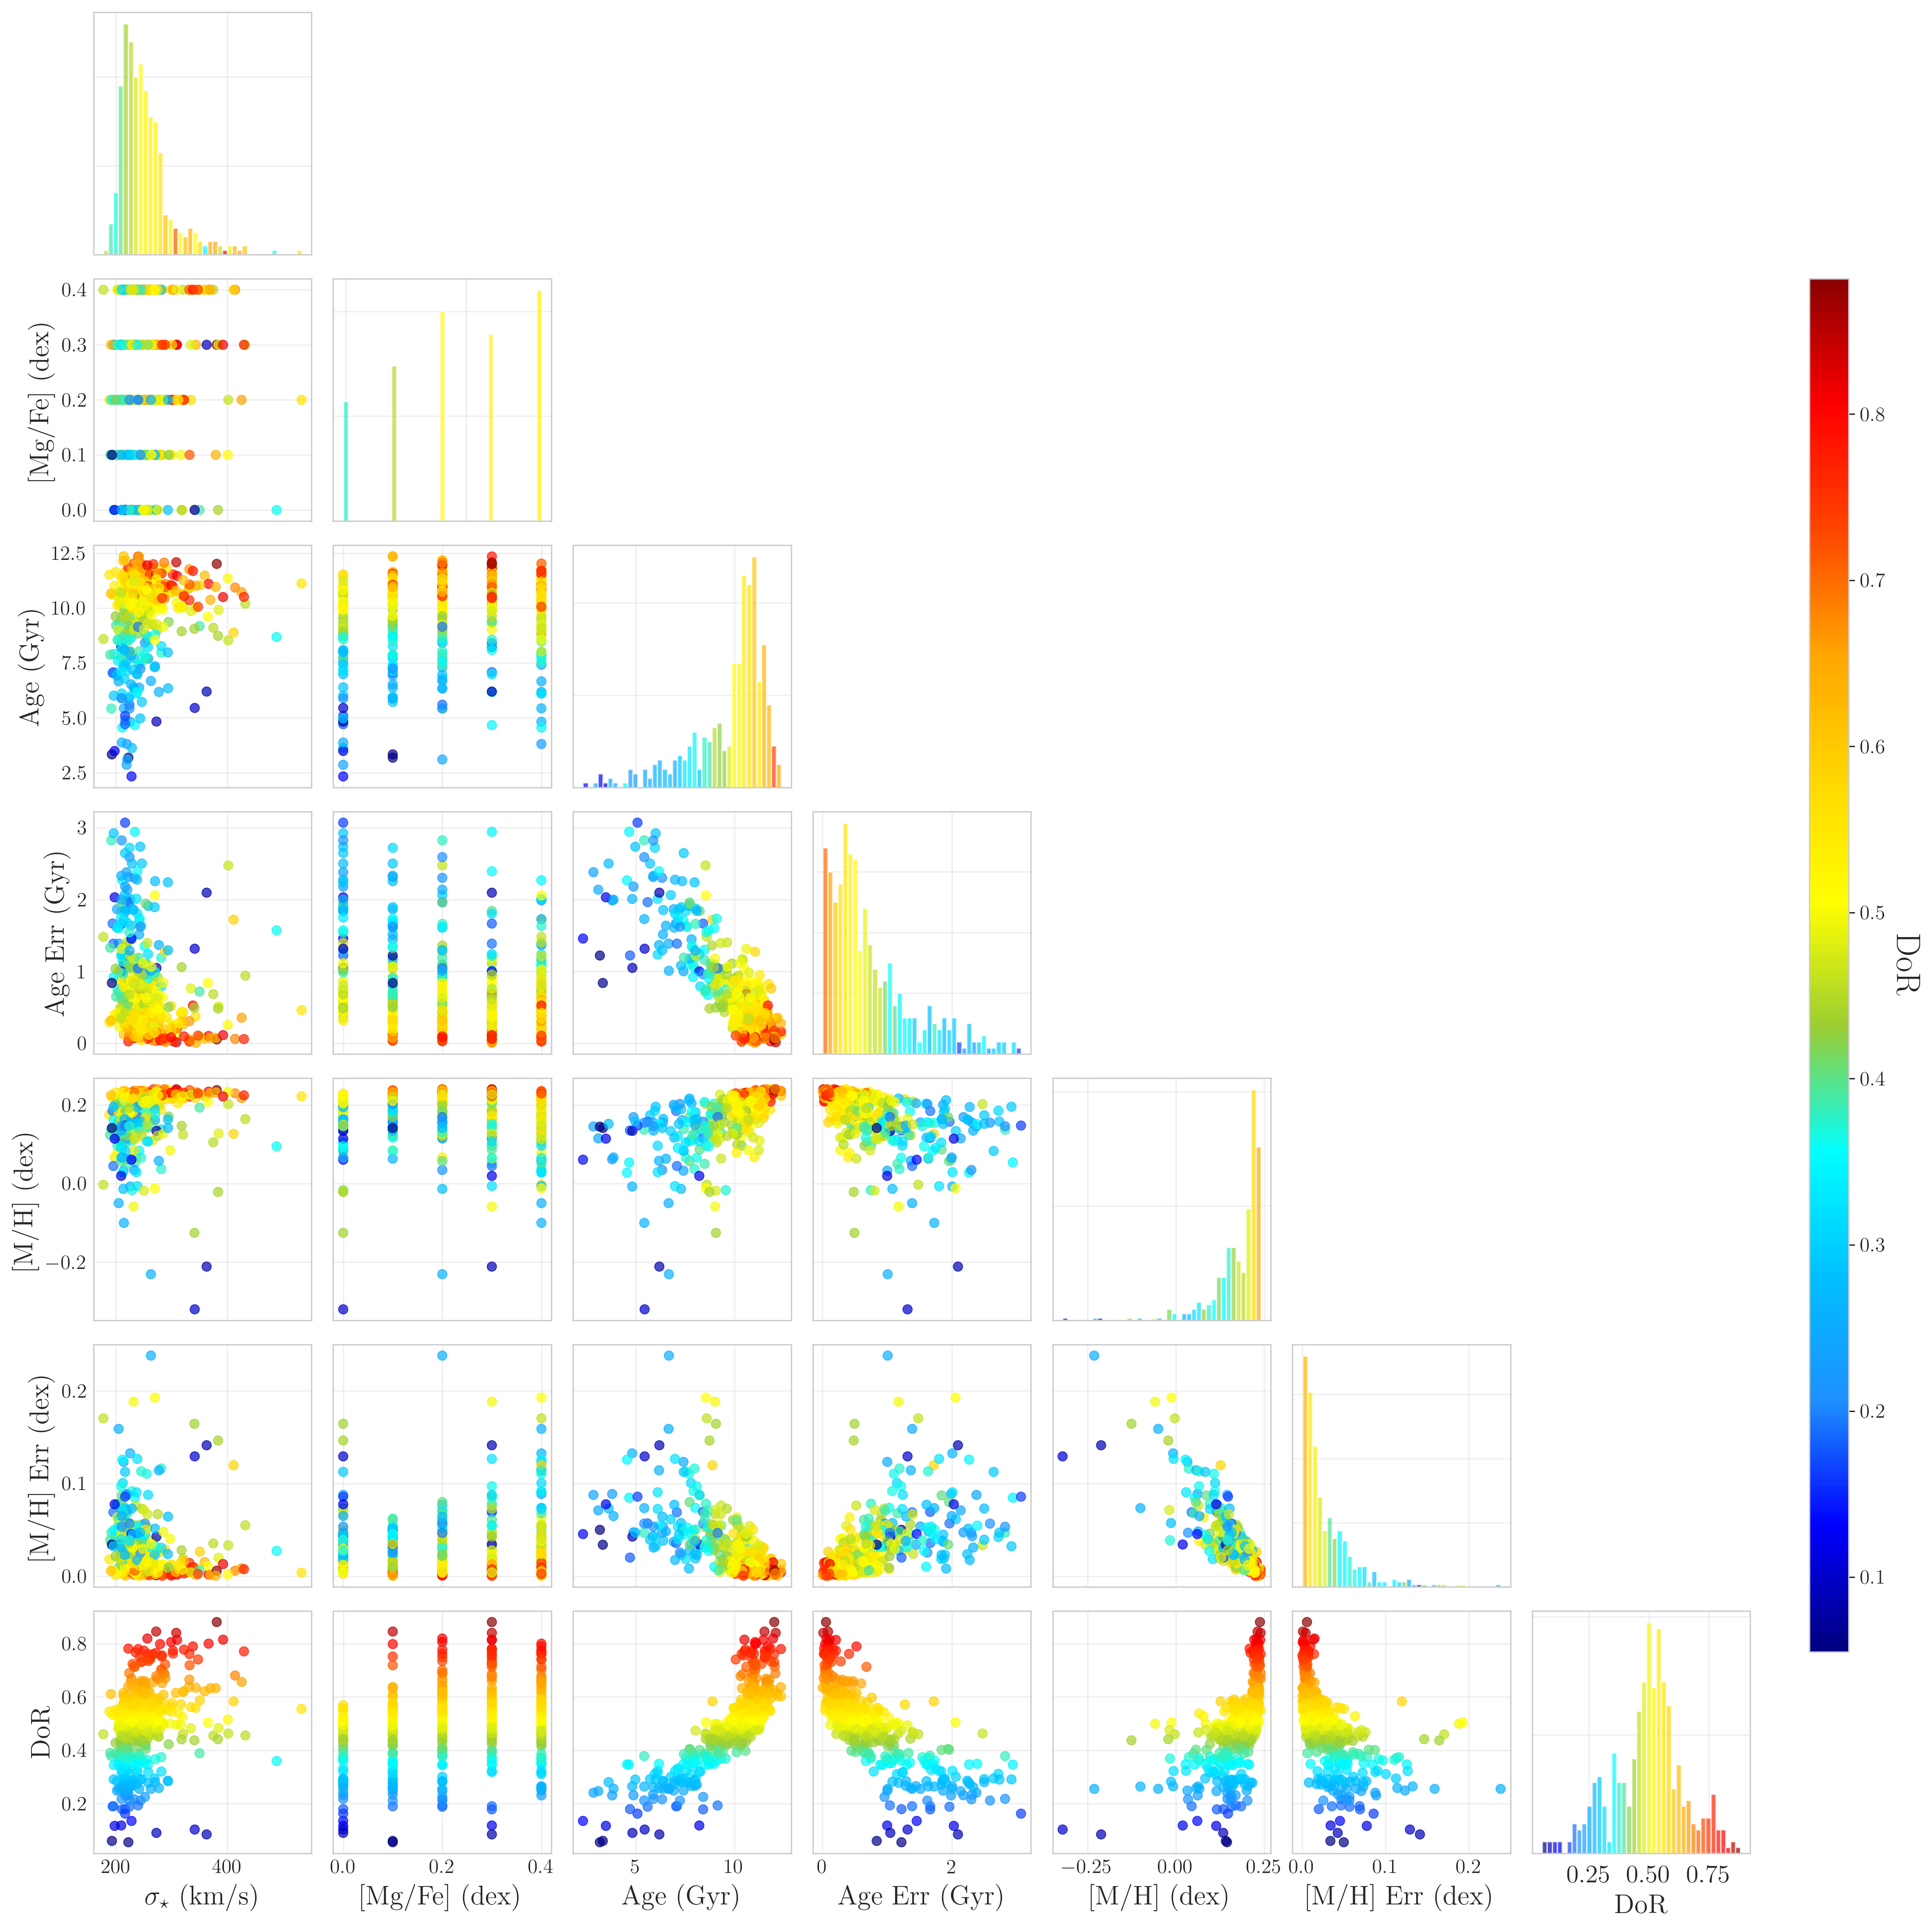

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


def create_corner_plots(df, features, feature_display_names=None, target='DoR', target_display_name=None):

    # Set LaTeX style to match the original code
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 15,
    })
    
    # Create display names dictionary if not provided
    if feature_display_names is None:
        feature_display_names = {f: f for f in features}
    
    # Set target display name if not provided
    if target_display_name is None:
        target_display_name = target
    
    # Create the first version with the target included as a feature
    # plot_features_with_target(df, features, feature_display_names, target, target_display_name)
    
    # Create the second version without the target but colored by the target
    plot_features_colored_by_target(df, features, feature_display_names, target, target_display_name)

def plot_features_with_target(df, features, feature_display_names, target='DoR', target_display_name=None):
    """Create a corner plot with all features including the target"""
    # Create a new figure
    fig = plt.figure(figsize=(16, 16))
    
    # If target display name not provided, use the target name
    if target_display_name is None:
        target_display_name = target
    
    # Include target in the feature list for this plot
    all_vars = features.copy()
    all_display_names = feature_display_names.copy()
    
    if target not in all_vars:
        all_vars.append(target)
        all_display_names[target] = target_display_name
    
    # Number of variables
    n_vars = len(all_vars)
    
    # Create subplots for each pair of variables
    for i in range(n_vars):
        for j in range(n_vars):
            # Create subplot
            ax = fig.add_subplot(n_vars, n_vars, i * n_vars + j + 1)
            
            if i == j:  # Diagonal: histogram
                # Draw the histogram
                sns.histplot(df[all_vars[i]], kde=True, ax=ax, color='steelblue', 
                            edgecolor='black', linewidth=0.8, alpha=0.7)
                
                # Remove title
                ax.set_title("")
                
                # Add "Count" as a title above the plot instead of as a y-label
                # ax.set_title("Count", fontsize=14, pad=10)
                
                # Remove x-label for diagonal histograms
                ax.set_xlabel("")
                
                # Only set x-label for the bottom row
                if i == n_vars - 1:
                    ax.set_xlabel(all_display_names[all_vars[i]], fontsize=16)
                
                # Remove y-label but keep y-tick labels
                ax.set_ylabel("")
                # Rotate y-ticks 45 degrees for better readability
                ax.tick_params(axis='y', rotation=45)
                
                # If not the bottom row, hide x-tick labels
                if i < n_vars - 1:
                    ax.set_xticklabels([])
                
                ax.grid(True, alpha=0.3)
            
            elif i > j:  # Lower triangle: scatter plots
                scatter = ax.scatter(df[all_vars[j]], df[all_vars[i]], 
                                    s=30, alpha=0.6, 
                                    edgecolors='k', linewidths=0.5)
                
                # Add grid
                ax.grid(True, alpha=0.3)
                
                # Set axis labels only for the bottom row and leftmost column
                # Use display names for labels
                if i == n_vars - 1:
                    ax.set_xlabel(all_display_names[all_vars[j]], fontsize=16)
                else:
                    ax.set_xlabel('')
                    
                if j == 0:
                    ax.set_ylabel(all_display_names[all_vars[i]], fontsize=16)
                else:
                    ax.set_ylabel('')
                
                # Only show tick labels on the edges
                if i < n_vars - 1:  # Not the bottom row
                    ax.set_xticklabels([])
                if j > 0:  # Not the leftmost column
                    ax.set_yticklabels([])
            
            else:  # Upper triangle: leave empty
                ax.axis('off')
            
            # Set ticks inward
            if i != j and i > j:
                ax.tick_params(axis='both', which='both', direction='in', labelsize=12)
                ax.minorticks_on()
    
    # Use larger wspace to increase horizontal spacing between subplots
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.3, hspace=0.1)
    plt.savefig(f'../outputs/make_plots_output/corner_plain{suffix}.pdf')
    
    return fig

def plot_features_colored_by_target(df, features, feature_display_names, target='DoR', target_display_name=None):
    """Create a corner plot with features colored by the target variable"""
    # Create a new figure
    fig = plt.figure(figsize=(16, 16))
    
    # If target display name not provided, use the target name
    if target_display_name is None:
        target_display_name = target
    
    # Number of variables
    n_vars = len(features)
    
    # Create a custom colormap with red for high values (inverted heat colors)
    colors = ["navy", "blue", "dodgerblue", "deepskyblue", "cyan", 
              "yellowgreen", "yellow", "gold", "orange", "orangered", "red", "darkred"]
    cmap = LinearSegmentedColormap.from_list("DoR_cmap", colors) 
    
    # Normalize the target variable for coloring
    norm = plt.Normalize(df[target].min(), df[target].max())
    
    # Create subplots for each pair of variables
    for i in range(n_vars):
        for j in range(n_vars):
            # Create subplot
            ax = fig.add_subplot(n_vars, n_vars, i * n_vars + j + 1)
            
            if i == j:  # Diagonal: histogram

                if features[i] == 'MgFe':
                    mgfe_values = [0.0, 0.1, 0.2, 0.3, 0.4]
                    
                    mgfe_custom_bins = []
                    for value in mgfe_values:
                        mgfe_custom_bins.append(value - 0.005)  # Small buffer below the value
                        mgfe_custom_bins.append(value + 0.005)  # Small buffer above the value
                    
                    mgfe_custom_bins.append(0.405)
                    
                    #mgfe_custom_bins = [max(0, bin_edge) for bin_edge in mgfe_custom_bins]
                    #mgfe_custom_bins = sorted(list(set(mgfe_custom_bins)))
                    
                    counts, bins, patches = ax.hist(df[features[i]], bins=mgfe_custom_bins, alpha=0.7, linewidth=0.8)
                else:
                    counts, bins, patches = ax.hist(df[features[i]], bins=40, alpha=0.7, linewidth=0.8)
                
                
                
                """
                bin_centers = 0.5 * (bins[:-1] + bins[1:])
                for count, x, patch in zip(counts, bin_centers, patches):
                    # Find indices of points in this bin
                    bin_mask = (df[features[i]] >= x - (bins[1]-bins[0])/2) & \
                              (df[features[i]] < x + (bins[1]-bins[0])/2)
                    
                    if any(bin_mask):
                        # Color by average DoR in this bin
                        avg_DoR = df.loc[bin_mask, target].mean()
                        patch.set_facecolor(cmap(norm(avg_DoR)))
                    else:
                        patch.set_facecolor('gray')"""
                    
                for idx, (patch, left_edge, right_edge) in enumerate(zip(patches, bins[:-1], bins[1:])):
                    # For the last bin, include the right edge
                    if idx == len(patches) - 1:
                        bin_mask = (df[features[i]] >= left_edge) & (df[features[i]] <= right_edge)
                    else:
                        bin_mask = (df[features[i]] >= left_edge) & (df[features[i]] < right_edge)
                    
                    if any(bin_mask):
                        avg_DoR = df.loc[bin_mask, target].mean()
                        patch.set_facecolor(cmap(norm(avg_DoR)))
                    else:
                        patch.set_facecolor('gray')
                
                # Add "Count" as a title above the plot instead of as a y-label
                # ax.set_title("Count", fontsize=14, pad=10)
                
                # Remove x-label for diagonal histograms
                ax.set_xlabel("")
                
                # Only set x-label for the bottom row
                if i == n_vars - 1:
                    ax.set_xlabel(feature_display_names[features[i]], fontsize=16)
                
                # Remove y-label but keep y-tick labels
                ax.set_ylabel("")
                # Rotate y-ticks 45 degrees for better readability
                # ax.tick_params(axis='y', rotation=45)
                ax.set_yticklabels([])

                
                # If not the bottom row, hide x-tick labels
                if i < n_vars - 1:
                    ax.set_xticklabels([])
                
                ax.grid(True, alpha=0.3)
            
            elif i > j:  # Lower triangle: scatter plots colored by target
                scatter = ax.scatter(df[features[j]], df[features[i]], 
                                    c=df[target], cmap=cmap, 
                                    s=30, alpha=0.7, linewidths=0.5)
                
                # Add grid
                ax.grid(True, alpha=0.3)
                
                # Set axis labels only for the bottom row and leftmost column
                # Use display names for labels
                if i == n_vars - 1:
                    ax.set_xlabel(feature_display_names[features[j]], fontsize=16)
                else:
                    ax.set_xlabel('')
                    
                if j == 0:
                    ax.set_ylabel(feature_display_names[features[i]], fontsize=16)
                else:
                    ax.set_ylabel('')
                
                # Only show tick labels on the edges
                if i < n_vars - 1:  # Not the bottom row
                    ax.set_xticklabels([])
                if j > 0:  # Not the leftmost column
                    ax.set_yticklabels([])
            
            else:  # Upper triangle: leave empty
                ax.axis('off')
            
            # Set ticks inward
            if i != j and i > j:
                ax.tick_params(axis='both', which='both', direction='in', labelsize=12)
                ax.minorticks_on()
    
    # Add colorbar to the right of the plot
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
    cbar.set_label(target_display_name, rotation=270, fontsize=20, labelpad=20)
    cbar_ax.tick_params(labelsize=12)
    
    # Use larger wspace to increase horizontal spacing between subplots
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.9)
    
    plt.savefig(f'../outputs/make_plots_output/corner_dor_coloured{suffix}.pdf')
    
    return fig

if __name__ == "__main__":
    
    FEATURES = [
        'velDisp_ppxf_res',
        # 'velDisp_ppxf_err_res',
        'MgFe',
        'age_mean_mass',
        'age_err_mass',
        '[M/H]_mean_mass',
        '[M/H]_err_mass',
        'DoR'
    ]
    
    # sigma, mgfe, age, age_err, metal, metal_err and dor
    
    # Define a mapping between feature names and display names
    # This is where you can customize how each feature appears in the plot
    FEATURE_DISPLAY_NAMES = {
       'MgFe': r'$[\mathrm{Mg}/\mathrm{Fe}]$ (dex)',          # Magnesium to Iron ratio
        '[M/H]_mean_mass': r'$[\mathrm{M}/\mathrm{H}]$ (dex)',               # Metallicity
        'velDisp_ppxf_res': r'$\sigma_{\star}$ (km/s)',                # Velocity dispersion
        'age_mean_mass': r'Age (Gyr)',                                  # Age in Gigayears
        
        'age_err_mass': r'Age Err (Gyr)',
        'velDisp_ppxf_err_res': r'$\sigma_{\star}$ Err (km/s)',
        '[M/H]_err_mass':'$[\mathrm{M}/\mathrm{H}]$ Err (dex)',
        'DoR':'DoR'
    }
    
    # Set a display name for the target variable
    TARGET_DISPLAY_NAME = r'$\mathrm{DoR}$'  # Degree of Rotation
    
    # Read your data
    df = pd.read_csv('../data/E-INSPIRE_I_master_catalogue.csv')
    
    # Create both types of corner plots with custom display names
    create_corner_plots(
        df, 
        FEATURES, 
        feature_display_names=FEATURE_DISPLAY_NAMES, 
        target='DoR',
        target_display_name=TARGET_DISPLAY_NAME
    )

## Figure 8 attempt two - with MEH 

In [219]:
def read_fits_summary_metal(fitsfile):
    
    hdu = fits.open(fitsfile)

    age_grid = hdu['age_grid'].data
    metal_grid = hdu['metal_grid'].data
    weights = hdu['pp_weights'].data.reshape(hdu['reg_dim'].data)

    name = hdu[0].header['name']
    z = hdu[0].header['z']
    hdu.close()
    del hdu

    ages = age_grid[:,0]
    metals = metal_grid[0,:]

    weights_rev = copy(weights[::-1,:])

    wei1 = []
    weiplot = []

    for i in range(len(ages)):
        x = np.sum([weights_rev[i,j]*metals[j] for j in range(len(metals))], axis=0)
        wei1.append(x)
        if np.sum(weights_rev[:i+1,:]) != 0:
            weiplot.append(np.sum(wei1)/np.sum(weights_rev[:i+1,:])) 
        else:
            weiplot.append(np.nan)

    # nedcalc = NedCalculator([z])
    nedcalc = NedCalculator(z) # or this?
    univ_age = nedcalc.zage_Gyr

    ages1 = univ_age - ages

    agesplot = np.concatenate([np.array([univ_age]), ages1])
    weiplot = np.concatenate([weiplot, np.array([weiplot[-1]])])

    agesplot = copy(agesplot[::-1])
    
    return name,z,agesplot,weiplot,univ_age

                                         filename
0  outputs/stacked_fits/stacked_REGRESSION_0.fits
1  outputs/stacked_fits/stacked_REGRESSION_2.fits


/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_25149/2000367113.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_mass.set_yticklabels([f"{tick*100:.0f}" for tick in ax_mass.get_yticks()])
/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_25149/2000367113.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


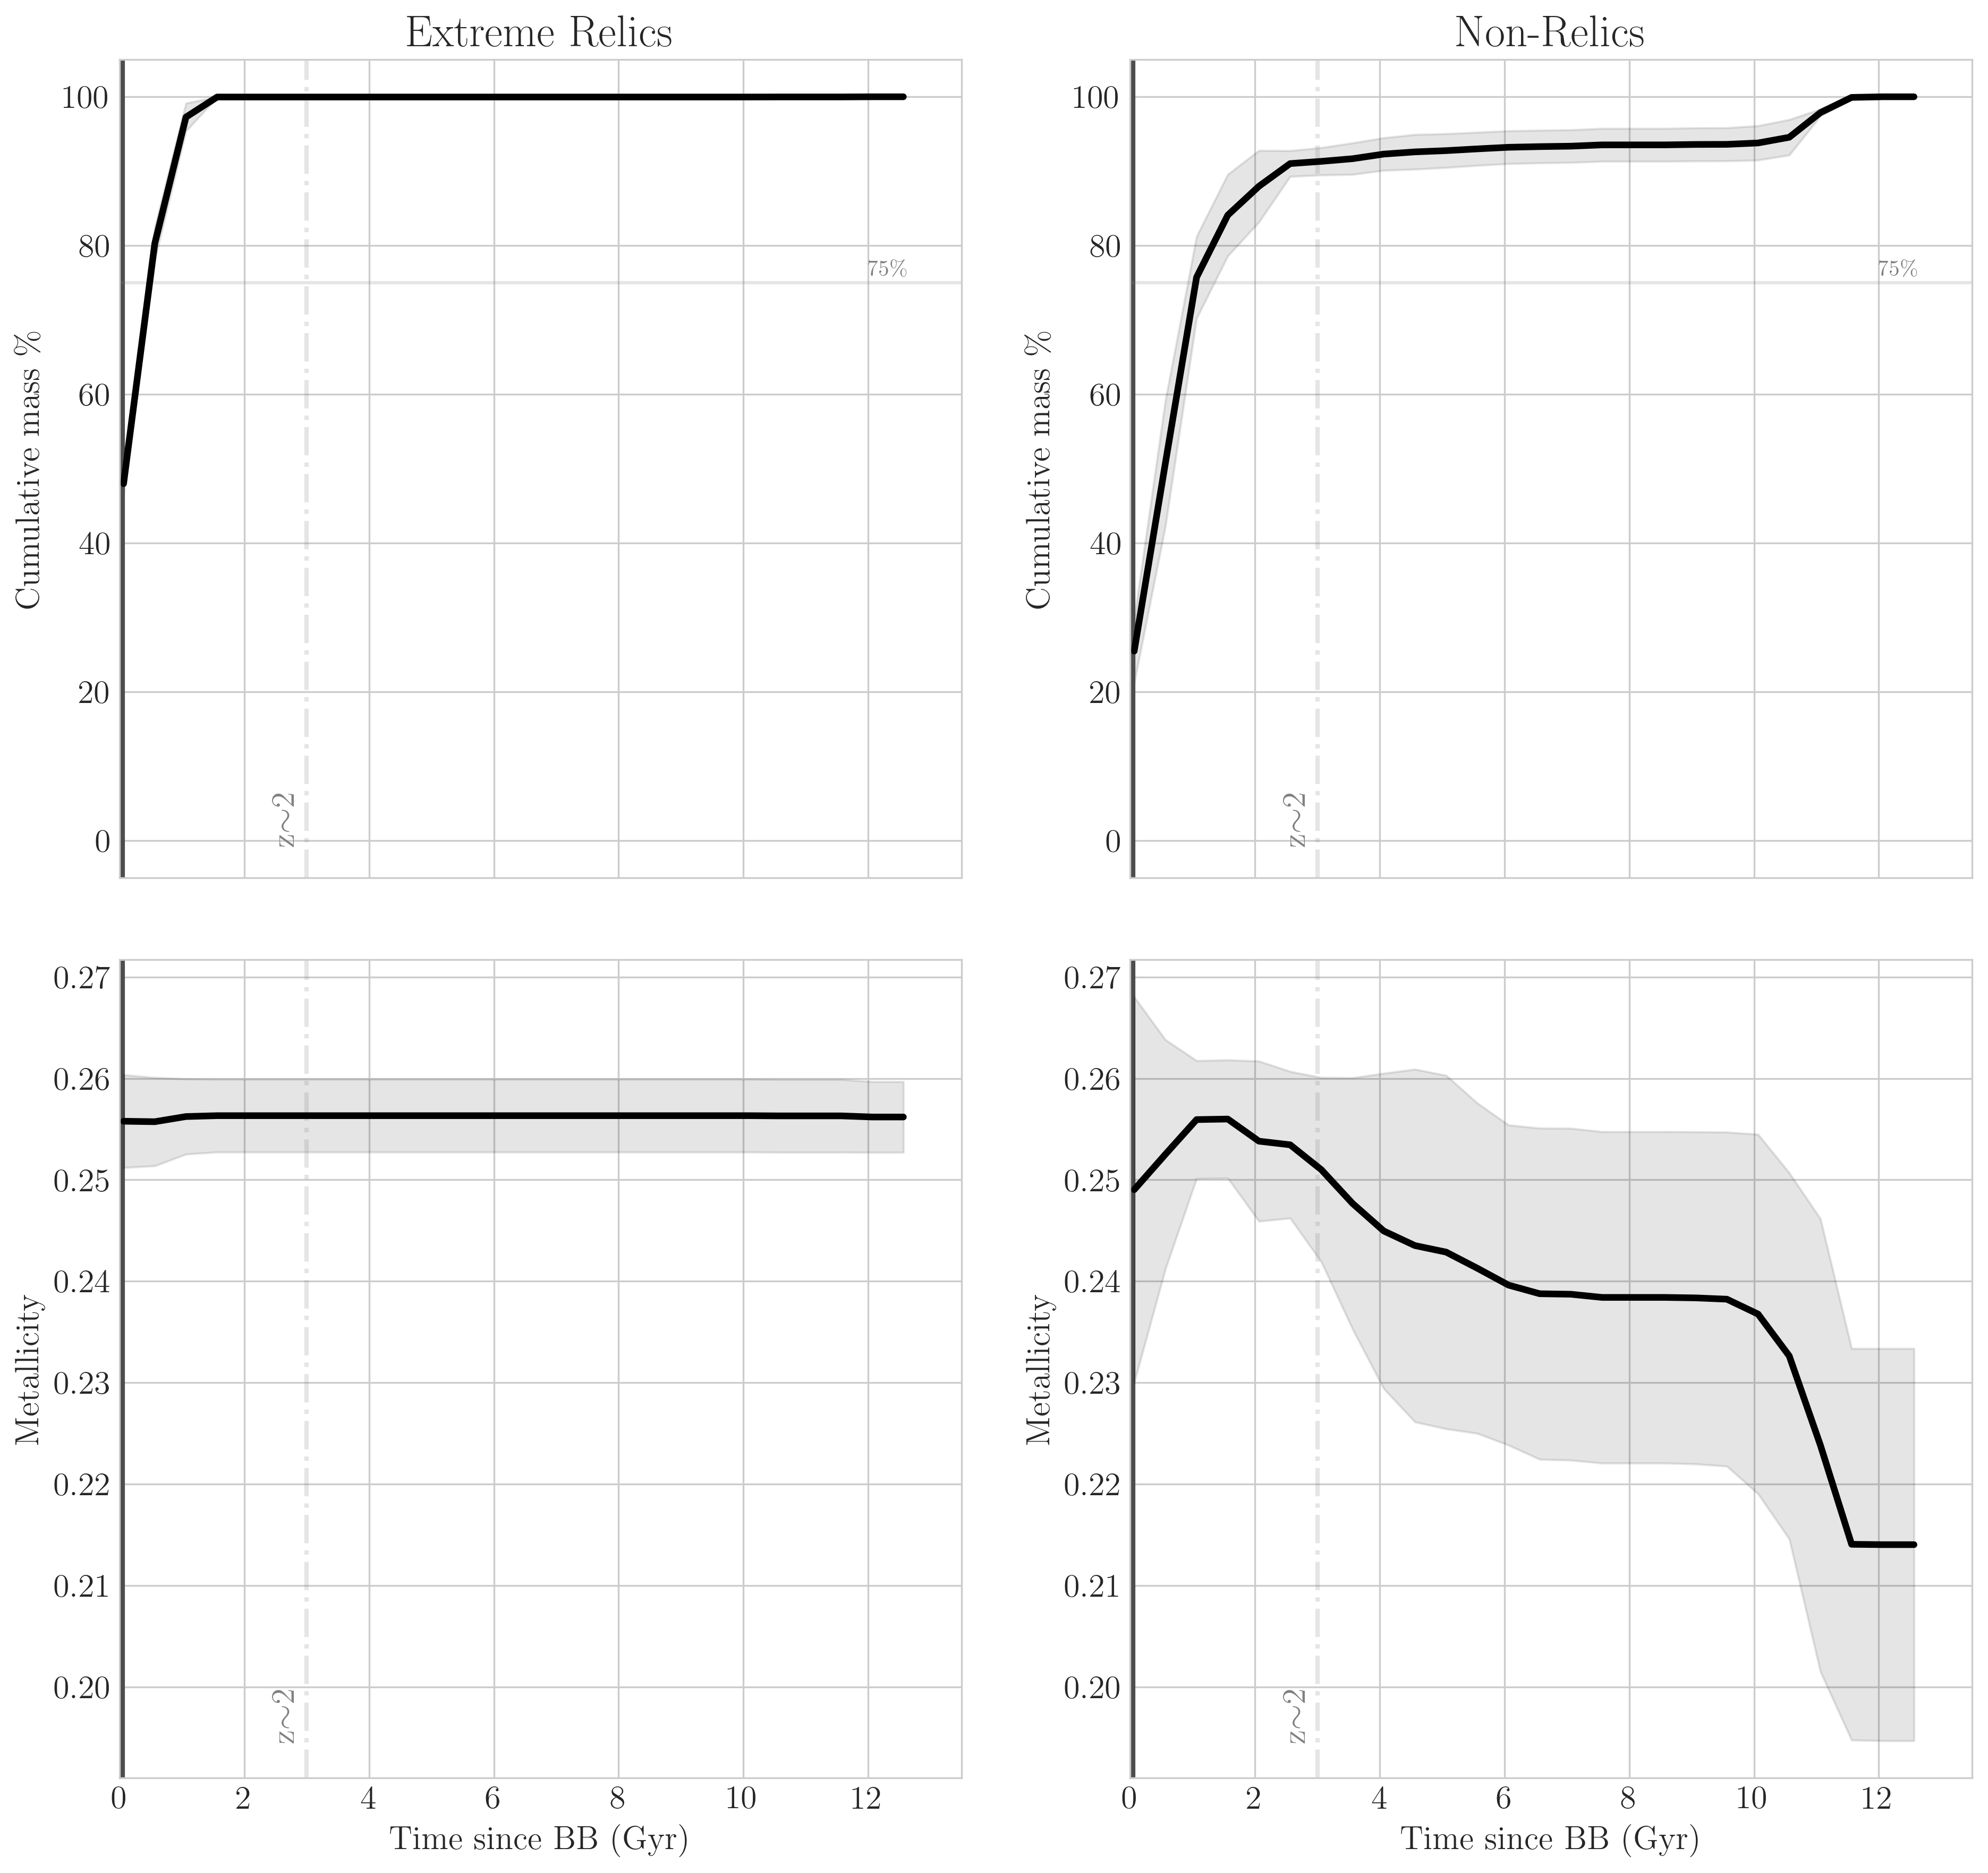

In [220]:
# Plotting just highest and lowest region

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from copy import copy
import matplotlib.gridspec as gridspec
from os.path import exists

def plot_mass_and_metal_evolution(df):
    fig = plt.figure(figsize=(15, 14))
    
    # Create a grid with 2 rows and 2 columns, with the mass plots on top and metallicity plots on bottom
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], hspace=0.1)
    
    # Create the four axes we need
    axs = [plt.subplot(gs[i, j]) for i in range(2) for j in range(2)]
    
    props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='black')
    
    # Setup for galaxy selection
    if len(df) == 3:
        galaxy_ids = [0, 2]
    else:
        galaxy_ids = [0, 1]
    
    df_subset = pd.DataFrame({
        "filename": [f"outputs/stacked_fits/stacked_REGRESSION_{id}.fits" for id in galaxy_ids]
    })
    print(df_subset)
    ymins = []
    ymaxs = []
    univ_ages = []
    
    for idx, (index, row) in enumerate(df_subset.iterrows()):
        # Get the file ID
        galaxy_id = galaxy_ids[idx]
        
        # File paths
        fitsfile1 = f'../outputs/ppxf_fits/stacked_REGRESSION_{galaxy_id}_ppxfout_UNR.fits'
        fitsfile2 = f'../outputs/ppxf_fits/stacked_REGRESSION_{galaxy_id}_ppxfout_REGUL.fits'
        
        # Optional files (following the pattern in paste.txt)
        fitsfilep = f'../outputs/ppxf_fits/stacked_REGRESSION_{galaxy_id}_ppxfout_plus.fits'
        fitsfilem = f'../outputs/ppxf_fits/stacked_REGRESSION_{galaxy_id}_ppxfout_minus.fits'
        
        # MASS PLOTS (TOP ROW)
        
        # Process mass evolution data
        name1, z1, agesplot1, weiplot1, univ_age1 = read_fits_summary(fitsfile1)
        name2, z2, agesplot2, weiplot2, univ_age2 = read_fits_summary(fitsfile2)
        
        masses = [weiplot1, weiplot2]
        
        # Check if optional files exist and process them
        if exists(fitsfilep):
            namep, zp, agesplotp, weiplotp, univ_agep = read_fits_summary(fitsfilep)
            masses.append(weiplotp)
                
        if exists(fitsfilem):
            namem, zm, agesplotm, weiplotm, univ_agem = read_fits_summary(fitsfilem)
            masses.append(weiplotm)
        
        mean_masses = np.mean(masses, axis=0)
        std_masses = np.std(masses, axis=0)
        
        # Plot mass evolution in the top row
        ax_mass = axs[idx]
        
        # Add custom labels for Extreme Relics and Non-Relics
        label = "Extreme Relics" if idx == 0 else "Non-Relics"
        
        ax_mass.set_xlim(0, 13.5)
        ax_mass.set_ylim(-0.05, 1.05)
        # Only set xlabel for bottom row
        ax_mass.set_ylabel(r'Cumulative mass \%', fontsize=15)
        ax_mass.minorticks_on()
        ax_mass.tick_params(axis='both', which='both', direction='in', labelsize=15)
        ax_mass.set_title(label, fontsize=20, weight='bold')
        
        ax_mass.axhline(0.75, color='gray', alpha=0.2)
        ax_mass.text(12, 0.76, r'75\%', style='italic', color='gray', fontsize=10)
        #ax_mass.axhline(0.3, color='gray', alpha=0.2)
        #ax_mass.text(12, 0.31, r'30\%', style='italic', color='gray', fontsize=10)
        ax_mass.axvline(3.0, color='gray', alpha=0.2, linestyle='-.', linewidth=2.0)
        #ax_mass.axvline(univ_age1, color='gray', linestyle='-.', linewidth=2.0)
        
        ax_mass.plot(agesplot1[1:], mean_masses[1:], color='black', linewidth=3.0)
        ax_mass.fill_between(agesplot1[1:], mean_masses[1:]-std_masses[1:], mean_masses[1:]+std_masses[1:], color='black', alpha=0.1)
        
        #ax_mass.text(univ_age1-0.1, 0.2, 'today', color='gray', style='italic', rotation=90, horizontalalignment='right', fontsize=15)
        ax_mass.text(2.9, 0.0, r'z$\sim$2', style='italic', color='gray', rotation=90, 
                horizontalalignment='right', fontsize=15)
        ax_mass.set_xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0])
        ax_mass.set_yticklabels([f"{tick*100:.0f}" for tick in ax_mass.get_yticks()])
        # METALLICITY PLOTS (BOTTOM ROW)
        
        # Process metallicity evolution data
        name1, z1, agesplot1, weiplot1, univ_age1 = read_fits_summary_metal(fitsfile1)
        name2, z2, agesplot2, weiplot2, univ_age2 = read_fits_summary_metal(fitsfile2)
        
        masses = [weiplot1, weiplot2]
        
        # Check if optional files exist and process them for metallicity
        if exists(fitsfilep):
            namep, zp, agesplotp, weiplotp, univ_agep = read_fits_summary_metal(fitsfilep)
            masses.append(weiplotp)
                
        if exists(fitsfilem):
            namem, zm, agesplotm, weiplotm, univ_agem = read_fits_summary_metal(fitsfilem)
            masses.append(weiplotm)
        
        mean_masses = np.nanmean(masses, axis=0)
        std_masses = np.nanstd(masses, axis=0)


        # Plot metallicity evolution in the bottom row
        ax_metal = axs[idx + 2]
        
        ax_metal.set_xlim(0, 13.5)
        ax_metal.set_xlabel('Time since BB (Gyr)', fontsize=15)
        ax_metal.set_ylabel('Metallicity', fontsize=15)
        ax_metal.minorticks_on()
        ax_metal.tick_params(axis='both', which='both', direction='in', labelsize=15)
        
        ax_metal.axvline(3.0, color='gray', alpha=0.2, linestyle='-.', linewidth=2.0)
        #ax_metal.axvline(univ_age1, color='gray', linestyle='-.', linewidth=2.0)
        
        # Gray out the earliest time
        ax_metal.axvspan(0., agesplot1.min(), color='0.3')
        ax_mass.axvspan(0., agesplot1.min(), color='0.3')
        
        ax_metal.plot(agesplot1, mean_masses, color='black', linewidth=3.0)
        ax_metal.fill_between(agesplot1, mean_masses-std_masses, mean_masses+std_masses, color='black', alpha=0.1)
        
        ax_metal.set_xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0])
        
        # Store y-limits and universe age for later adjustment
        ymin, ymax = ax_metal.get_ylim()
        ymins.append(ymin)
        ymaxs.append(ymax)
        univ_ages.append(univ_age1)
    
    # Hide x-tick labels for top row
    for i in [0, 1]:
        plt.setp(axs[i].get_xticklabels(), visible=False)
    
    # Apply consistent y-limits to metallicity plots
    ymin = min(ymins)
    ymax = max(ymaxs)
    
    for i in range(2):
        univ_age = univ_ages[i]
        ax_metal = axs[i + 2]
        
        ax_metal.set_ylim(ymin, ymax)
        # ax_metal.text(univ_age-0.1, ymin+0.22*(ymax-ymin), 'today', color='gray', style='italic', rotation=90, horizontalalignment='right', fontsize=15)
        ax_metal.text(2.9, ymin+0.05*(ymax-ymin), r'z$\sim$2', style='italic', color='gray', 
                     rotation=90, horizontalalignment='right', fontsize=15)
    
    # Align ylabels
    fig.align_ylabels([axs[0], axs[2]])
    fig.align_ylabels([axs[1], axs[3]])
    
    plt.tight_layout()
    name = '../outputs/make_plots_output/mass_metal_evolution'+suffix+'.pdf'
    plt.savefig(name, bbox_inches='tight', dpi=300)

# Call the function (assuming df is defined)
df = pd.read_csv('../outputs/stacked_catalogues/CATALOGUE_REGRESSION.csv')
plot_mass_and_metal_evolution(df)

                                         filename
0  outputs/stacked_fits/stacked_REGRESSION_0.fits
1  outputs/stacked_fits/stacked_REGRESSION_1.fits
2  outputs/stacked_fits/stacked_REGRESSION_2.fits


/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_25149/3769430205.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_mass.set_yticklabels([f"{tick*100:.0f}" for tick in ax_mass.get_yticks()])
/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_25149/3769430205.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


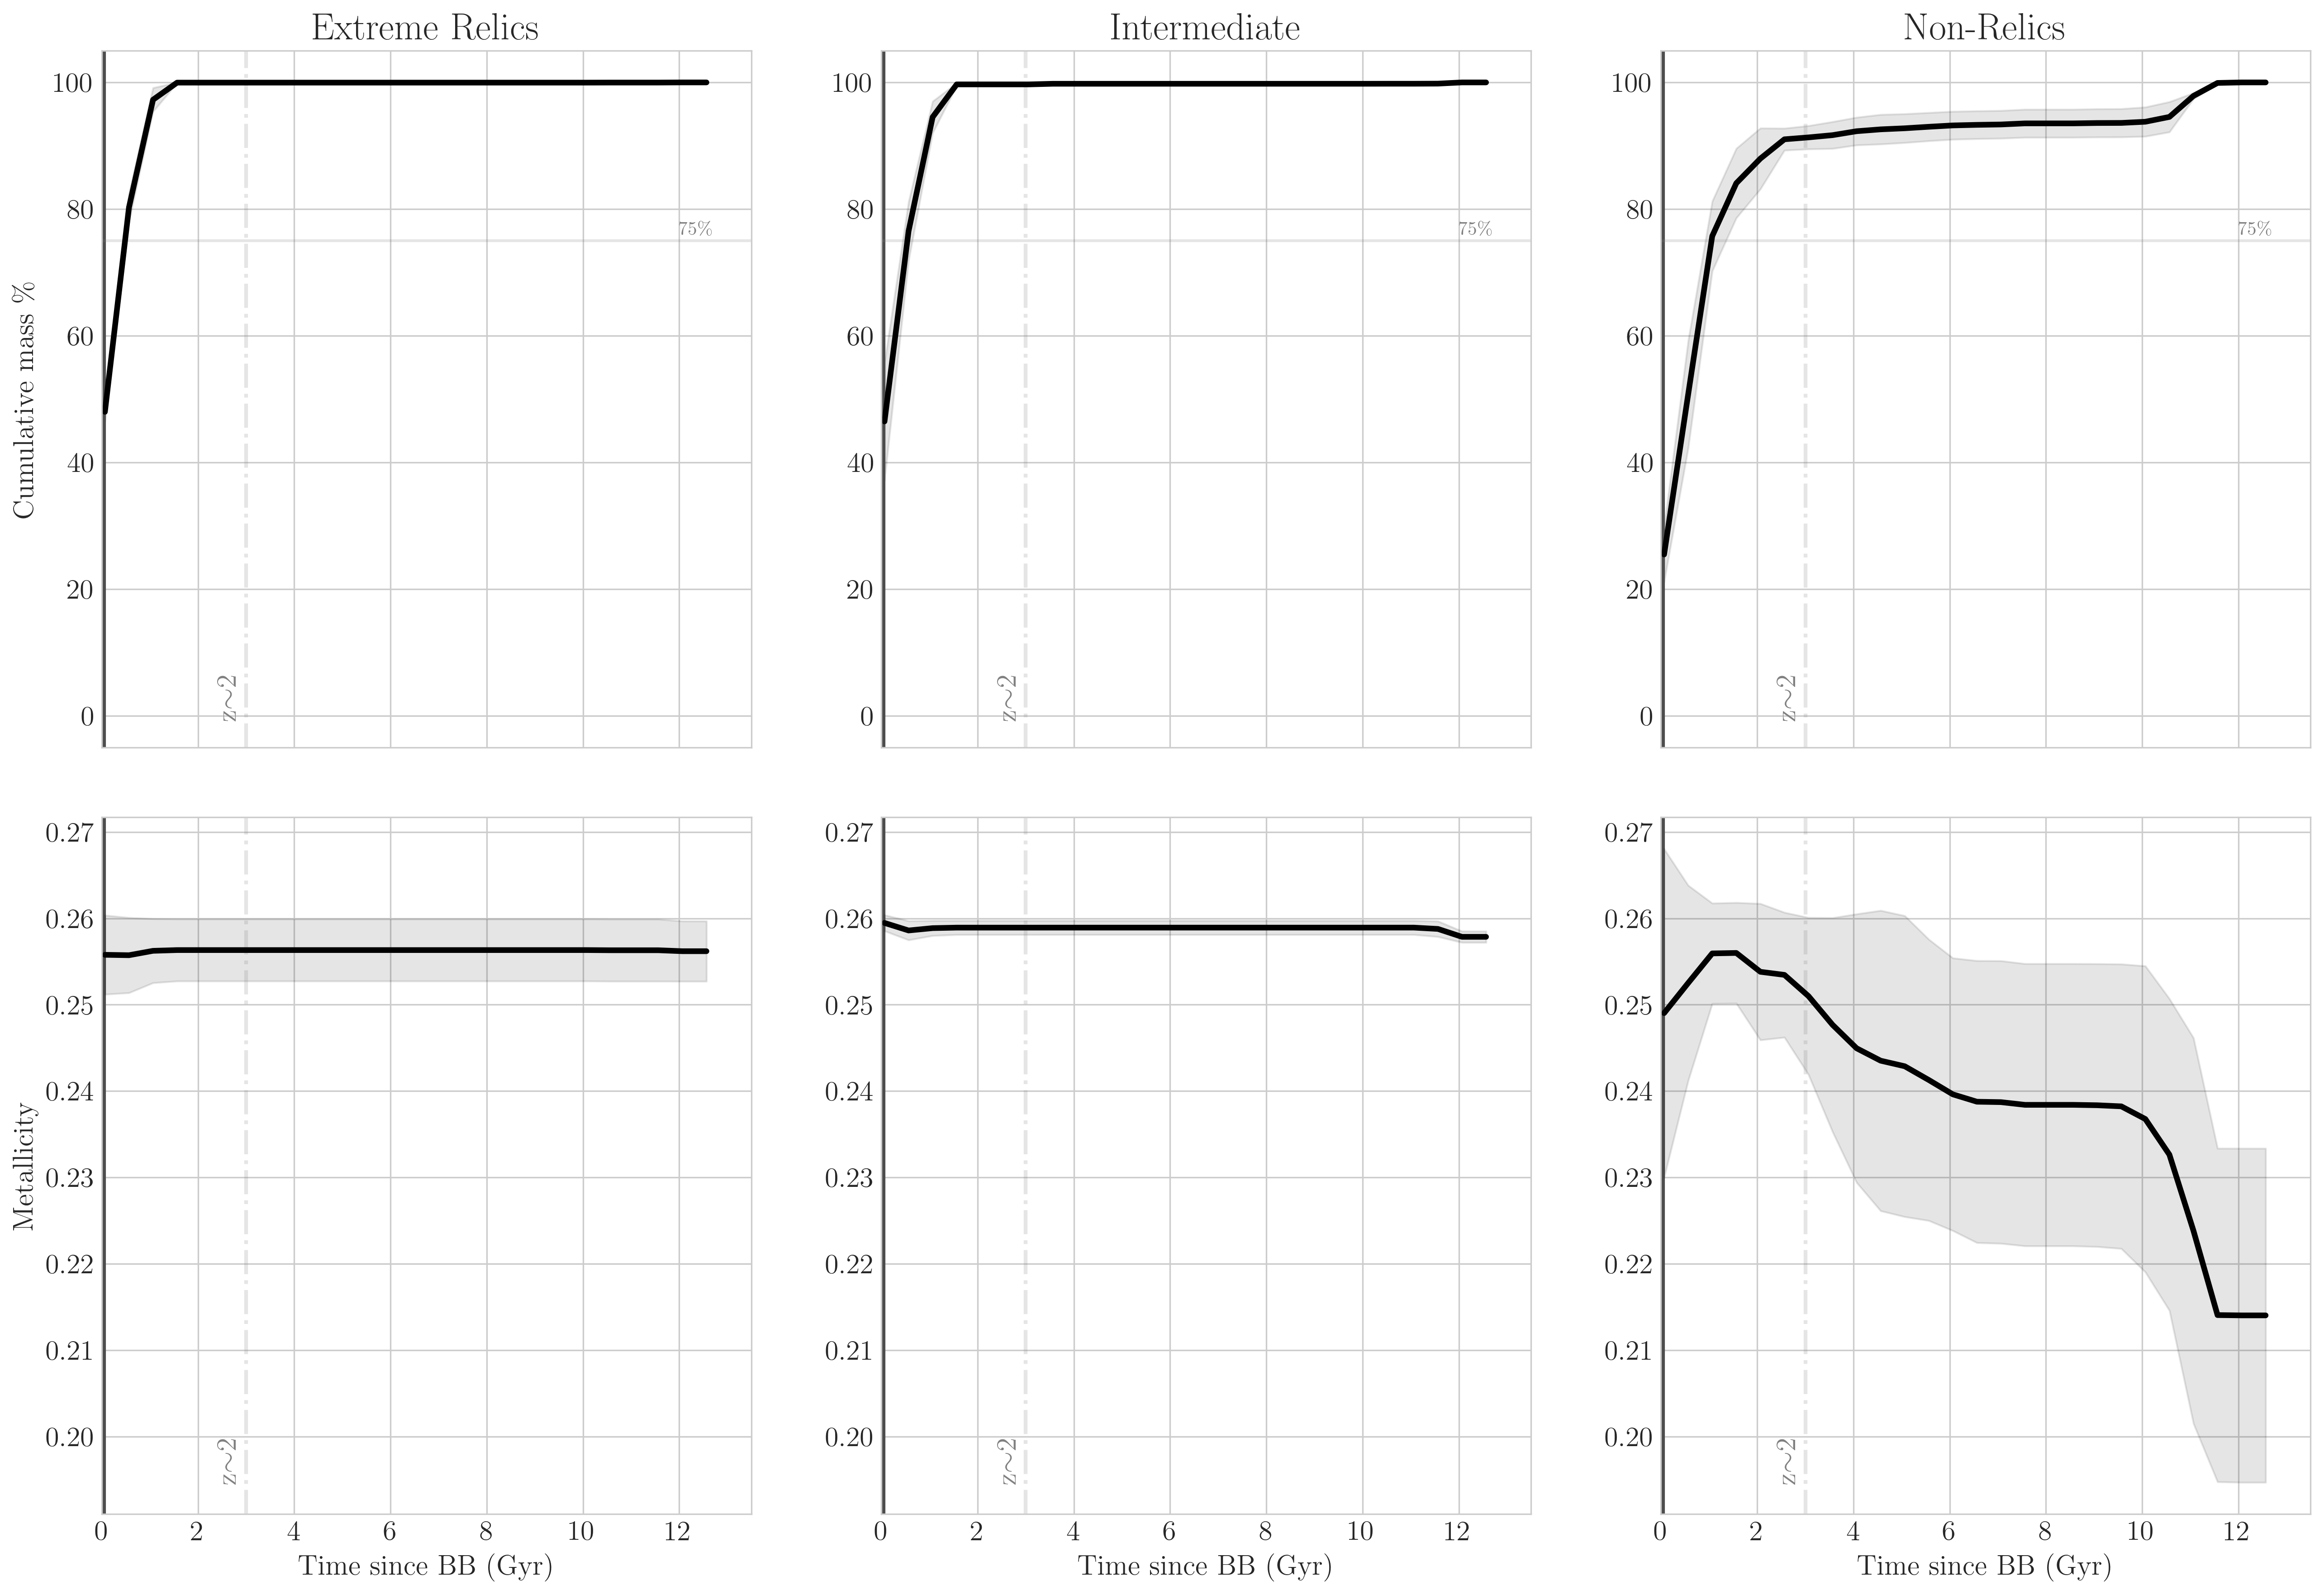

In [221]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from copy import copy
import matplotlib.gridspec as gridspec
from os.path import exists

def plot_mass_and_metal_evolution(df):
    fig = plt.figure(figsize=(21, 14))  # Wider figure to accommodate 3 columns
    
    # Create a grid with 2 rows and 3 columns, with the mass plots on top and metallicity plots on bottom
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], hspace=0.1)
    
    # Create the six axes we need (3 columns × 2 rows)
    axs = [plt.subplot(gs[i, j]) for i in range(2) for j in range(3)]
    
    props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='black')
    
    # Setup for galaxy selection - now using all three galaxies
    galaxy_ids = [0, 1, 2]
    
    df_subset = pd.DataFrame({
        "filename": [f"outputs/stacked_fits/stacked_REGRESSION_{id}.fits" for id in galaxy_ids]
    })
    print(df_subset)
    ymins = []
    ymaxs = []
    univ_ages = []
    
    # Custom labels for the three galaxy types
    labels = ["Extreme Relics", "Intermediate", "Non-Relics"]
    
    for idx, (index, row) in enumerate(df_subset.iterrows()):
        # Get the file ID
        galaxy_id = galaxy_ids[idx]
        
        # File paths
        fitsfile1 = f'../outputs/ppxf_fits/stacked_REGRESSION_{galaxy_id}_ppxfout_UNR.fits'
        fitsfile2 = f'../outputs/ppxf_fits/stacked_REGRESSION_{galaxy_id}_ppxfout_REGUL.fits'
        
        # Optional files
        fitsfilep = f'../outputs/ppxf_fits/stacked_REGRESSION_{galaxy_id}_ppxfout_plus.fits'
        fitsfilem = f'../outputs/ppxf_fits/stacked_REGRESSION_{galaxy_id}_ppxfout_minus.fits'
        
        # MASS PLOTS (TOP ROW)
        
        # Process mass evolution data
        name1, z1, agesplot1, weiplot1, univ_age1 = read_fits_summary(fitsfile1)
        name2, z2, agesplot2, weiplot2, univ_age2 = read_fits_summary(fitsfile2)
        
        masses = [weiplot1, weiplot2]
        
        # Check if optional files exist and process them
        if exists(fitsfilep):
            namep, zp, agesplotp, weiplotp, univ_agep = read_fits_summary(fitsfilep)
            masses.append(weiplotp)
                
        if exists(fitsfilem):
            namem, zm, agesplotm, weiplotm, univ_agem = read_fits_summary(fitsfilem)
            masses.append(weiplotm)
        
        mean_masses = np.mean(masses, axis=0)
        std_masses = np.std(masses, axis=0)
        
        # Plot mass evolution in the top row
        ax_mass = axs[idx]
        
        # Use custom label for this galaxy type
        label = labels[idx]
        
        ax_mass.set_xlim(0, 13.5)
        ax_mass.set_ylim(-0.05, 1.05)
        # Only set xlabel for bottom row
        if idx == 0:  # Only add y-label to the first column
            ax_mass.set_ylabel(r'Cumulative mass \%', fontsize=15)
        ax_mass.minorticks_on()
        ax_mass.tick_params(axis='both', which='both', direction='in', labelsize=15)
        ax_mass.set_title(label, fontsize=20, weight='bold')
        
        ax_mass.axhline(0.75, color='gray', alpha=0.2)
        ax_mass.text(12, 0.76, r'75\%', style='italic', color='gray', fontsize=10)
        #ax_mass.axhline(0.3, color='gray', alpha=0.2)
        #ax_mass.text(12, 0.31, r'30\%', style='italic', color='gray', fontsize=10)
        ax_mass.axvline(3.0, color='gray', alpha=0.2, linestyle='-.', linewidth=2.0)
        #ax_mass.axvline(univ_age1, color='gray', linestyle='-.', linewidth=2.0)
        
        ax_mass.plot(agesplot1[1:], mean_masses[1:], color='black', linewidth=3.0)
        ax_mass.fill_between(agesplot1[1:], mean_masses[1:]-std_masses[1:], mean_masses[1:]+std_masses[1:], color='black', alpha=0.1)
        
        #ax_mass.text(univ_age1-0.1, 0.2, 'today', color='gray', style='italic', rotation=90, horizontalalignment='right', fontsize=15)
        ax_mass.text(2.9, 0.0, r'z$\sim$2', style='italic', color='gray', rotation=90, 
                horizontalalignment='right', fontsize=15)
        ax_mass.set_xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0])
        ax_mass.set_yticklabels([f"{tick*100:.0f}" for tick in ax_mass.get_yticks()])
        # METALLICITY PLOTS (BOTTOM ROW)
        
        # Process metallicity evolution data
        name1, z1, agesplot1, weiplot1, univ_age1 = read_fits_summary_metal(fitsfile1)
        name2, z2, agesplot2, weiplot2, univ_age2 = read_fits_summary_metal(fitsfile2)
        
        masses = [weiplot1, weiplot2]
        
        # Check if optional files exist and process them for metallicity
        if exists(fitsfilep):
            namep, zp, agesplotp, weiplotp, univ_agep = read_fits_summary_metal(fitsfilep)
            masses.append(weiplotp)
                
        if exists(fitsfilem):
            namem, zm, agesplotm, weiplotm, univ_agem = read_fits_summary_metal(fitsfilem)
            masses.append(weiplotm)
        
        mean_masses = np.nanmean(masses, axis=0)
        std_masses = np.nanstd(masses, axis=0)

        # Plot metallicity evolution in the bottom row
        ax_metal = axs[idx + 3]  # Now we have 3 columns so +3 to get to bottom row
        
        ax_metal.set_xlim(0, 13.5)
        ax_metal.set_xlabel('Time since BB (Gyr)', fontsize=15)
        if idx == 0:  # Only add y-label to the first column
            ax_metal.set_ylabel('Metallicity', fontsize=15)
        ax_metal.minorticks_on()
        ax_metal.tick_params(axis='both', which='both', direction='in', labelsize=15)
        
        ax_metal.axvline(3.0, color='gray', alpha=0.2, linestyle='-.', linewidth=2.0)
        #ax_metal.axvline(univ_age1, color='gray', linestyle='-.', linewidth=2.0)
        
        # Gray out the earliest time
        ax_metal.axvspan(0., agesplot1.min(), color='0.3')
        ax_mass.axvspan(0., agesplot1.min(), color='0.3')
        
        ax_metal.plot(agesplot1, mean_masses, color='black', linewidth=3.0)
        ax_metal.fill_between(agesplot1, mean_masses-std_masses, mean_masses+std_masses, color='black', alpha=0.1)
        
        ax_metal.set_xticks([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0])
        
        # Store y-limits and universe age for later adjustment
        ymin, ymax = ax_metal.get_ylim()
        ymins.append(ymin)
        ymaxs.append(ymax)
        univ_ages.append(univ_age1)
    
    # Hide x-tick labels for top row
    for i in range(3):  # Now we have 3 columns
        plt.setp(axs[i].get_xticklabels(), visible=False)
    
    # Apply consistent y-limits to metallicity plots
    ymin = min(ymins)
    ymax = max(ymaxs)
    
    for i in range(3):  # Now we have 3 columns
        univ_age = univ_ages[i]
        ax_metal = axs[i + 3]  # Bottom row starts at index 3
        
        ax_metal.set_ylim(ymin, ymax)
        # ax_metal.text(univ_age-0.1, ymin+0.22*(ymax-ymin), 'today', color='gray', style='italic', rotation=90, horizontalalignment='right', fontsize=15)
        ax_metal.text(2.9, ymin+0.05*(ymax-ymin), r'z$\sim$2', style='italic', color='gray', 
                     rotation=90, horizontalalignment='right', fontsize=15)
    
    # Align ylabels
    fig.align_ylabels([axs[0], axs[3]])  # Align first column ylabels
    
    plt.tight_layout()
    name = '../outputs/make_plots_output/mass_metal_evolution_all_3'+suffix+'.pdf'
    plt.savefig(name, bbox_inches='tight', dpi=300)

# Call the function (assuming df is defined)
df = pd.read_csv('../outputs/stacked_catalogues/CATALOGUE_REGRESSION.csv')

if len(df)==3:
    plot_mass_and_metal_evolution(df)